# Recomendador de inversiones inmoviliarias

## Datos origen:

- [Precio_medio_EUR_m2_alquiler](datasets/Precio_medio_EUR_m2_alquiler.csv)
- [Precio_medio_EUR_m2_compraventa](datasets/Precio_medio_EUR_m2_compraventa.csv)
- [BarcelonaCiutat_SeccionsCensals](datasets/BarcelonaCiutat_SeccionsCensals.csv)
- [idealista_datafile](datasets/idealista_datafile.csv)


## Tareas:

1. Dentificar toda la jerarquia de distritos y barrios
1. Modelo de ML para extrapolar precios estadístico de alquiler y compraventa a fecha de hoy
1. Asignar precio estadístico de alquiler y compraventa a cada inmueble basado en su barrio o distrito
1. Crear una puntuación para cada barrio o distrito de 0 a 1
1. Crear una puntuación para el precio de compra para cada inmueble de 0 a 1 en función del precio estadístico de compra de cada barrio o distrito
1. Crear una puntuación para el precio de alquiler para cada inmueble de 0 a 1 en función del precio estadístico de alquiler de cada barrio o distrito
1. Calcular la tasa de retorno de cada inmueble en función del precio de compra y el precio de alquiler
1. Crear una puntuación final para cada inmueble de 0 a 1 en función de las puntuaciones anteriores


In [42]:
!pip install openpyxl scikit-learn

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

Renta media mensual por superficie (€/m²) de alquiler de viviendas procedente de la estadística de fianzas del INCASOL. Se puede considerar que esta estadística tiene un carácter censal ya que se basa en el recuento de todos los contratos de alquiler que han depositado la fianza en el Incasòl en el período considerado.

La información de distritos y barrios está elaborada a partir de aquéllos viviendas que se han podido geolocalizar. El total de Barcelona puede no coincidir con la suma de compraventas de los distritos o de los barrios.No se publica la información de los ámbitos de menos de seis contratos registrados.

In [44]:
# Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

# Cargar estructura de jerarquica de municipio - distrito - barrio
# SeccionsCensals = pd.read_csv('datasets/BarcelonaCiutat_SeccionsCensals.csv')
# barrios = SeccionsCensals.groupby('nom_barri').min().drop(['codi_seccio_censal','geometria_etrs89','geometria_wgs84','codi_aeb'], axis=1).sort_values(by='codi_barri').reset_index().copy()

bcn_precios_int = pd.read_csv('datasets/gen_bcn_precios_int.csv')
bcn_precios = pd.read_csv('datasets/gen_bcn_precios.csv')

# Conversión de mes a periodo
bcn_precios_int['mes'] = pd.to_datetime(bcn_precios_int['mes'])#.dt.to_period('M')
bcn_precios['mes'] = pd.to_datetime(bcn_precios['mes'])#.dt.to_period('M')

bcn_precios

tipo                         nombre                       mes  \
0      municipi                      barcelona 2014-01-01 00:00:00+00:00   
1      municipi                      barcelona 2014-02-01 00:00:00+00:00   
2      municipi                      barcelona 2014-03-01 00:00:00+00:00   
3      municipi                      barcelona 2014-04-01 00:00:00+00:00   
4      municipi                      barcelona 2014-05-01 00:00:00+00:00   
...         ...                            ...                       ...   
10960     barri  vilapicina i la torre llobeta 2024-05-01 00:00:00+00:00   
10961     barri  vilapicina i la torre llobeta 2024-06-01 00:00:00+00:00   
10962     barri  vilapicina i la torre llobeta 2024-07-01 00:00:00+00:00   
10963     barri  vilapicina i la torre llobeta 2024-08-01 00:00:00+00:00   
10964     barri  vilapicina i la torre llobeta 2024-09-01 00:00:00+00:00   

       precio_alquiler  precio_venta  codi_districte nom_districte  codi_barri  
0            10.183474   2283.678228              -1           NaN          -1  
1                  NaN   2279.256975              -1           NaN          -1  
2                  NaN   2195.486111              -1           NaN          -1  
3            10.265500   2271.519231              -1           NaN          -1  
4                  NaN   2337.702170              -1           NaN          -1  
...                ...           ...             ...           ...         ...  
10960              NaN   2818.066667               8    nou barris          44  
10961              NaN   3565.214286               8    nou barris          44  
10962              NaN   3495.058824               8    nou barris          44  
10963              NaN   3060.500000               8    nou barris          44  
10964              NaN           NaN               8    nou barris          44  

[10965 rows x 8 columns]

## Análisis de distribución de datos en el Dataset

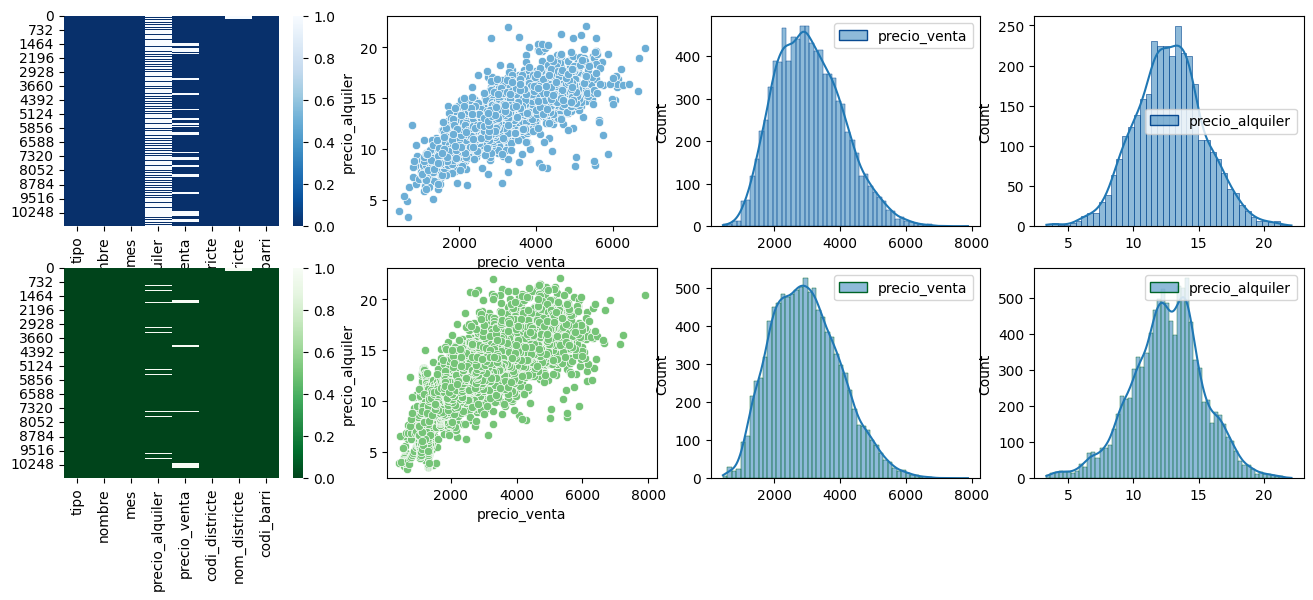

In [45]:
import matplotlib.cm as cm

def plot_data_dist(dfs):

    cmaps = ['Blues_r', 'Greens_r', 'Oranges_r', 'Reds_r', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'PuBuGn', 'PuRd', 'OrRd', 'YlGnBu', 'YlGn', 'YlOrBr', 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'YlOrRd']

    fig, axs = plt.subplots(len(dfs), 4, figsize=(16, 3*len(dfs)))
    # plt.grid(True)
    # Crear subplots
    for idx, df in enumerate(dfs):
        sns.heatmap(df.isnull(), annot=False, cmap=cmaps[idx], ax=axs[idx, 0] if len(dfs) > 1 else axs[0])
        sns.scatterplot(df, x='precio_venta', y='precio_alquiler', color=cm.get_cmap(cmaps[idx])(0.5), ax=axs[idx, 1] if len(dfs) > 1 else axs[1])
        sns.histplot(df[['precio_venta']], kde=True, color=cm.get_cmap(cmaps[idx])(0.5), edgecolor=cm.get_cmap(cmaps[idx])(0.1), ax=axs[idx, 2] if len(dfs) > 1 else axs[2])
        sns.histplot(df[['precio_alquiler']], kde=True, color=cm.get_cmap(cmaps[idx])(0.5), edgecolor=cm.get_cmap(cmaps[idx])(0.1), ax=axs[idx, 3] if len(dfs) > 1 else axs[3])
    plt.show()

plot_data_dist([bcn_precios, bcn_precios_int])

tipo  count
0      barri   9546
1  districte   1290
2   municipi    129

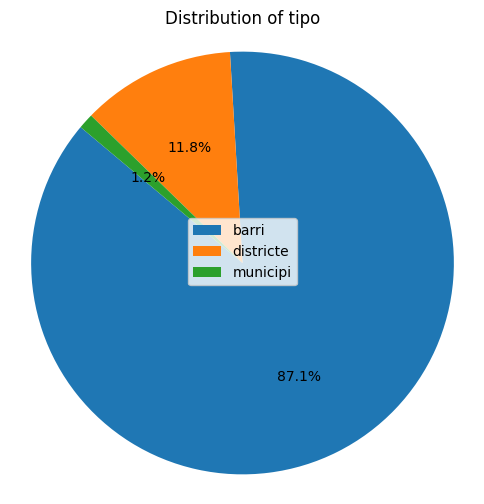

nom_districte  count
0           nou barris   1806
1       horta guinardo   1548
2           sant marti   1419
3       sants montjuic   1290
4          sant andreu   1032
5             eixample    903
6  sarria sant gervasi    903
7               gracia    774
8         ciutat vella    645
9            les corts    516

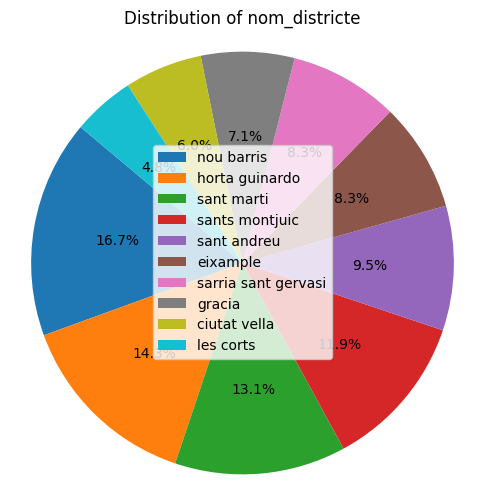

In [46]:
for c in ['tipo', 'nom_districte']:
    reason_counts = bcn_precios[c].value_counts()
    display(reason_counts.reset_index())
    # Create a pie plot using Seaborn for the 'status' column
    fig = plt.figure(figsize=(6,6))
    plt.title(f'Distribution of {c}')
    plt.pie(reason_counts, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    fig.legend(loc='center', labels=reason_counts.index)
    plt.show()

Gráfico de dispersión de precio_alquiler vs precio_venta


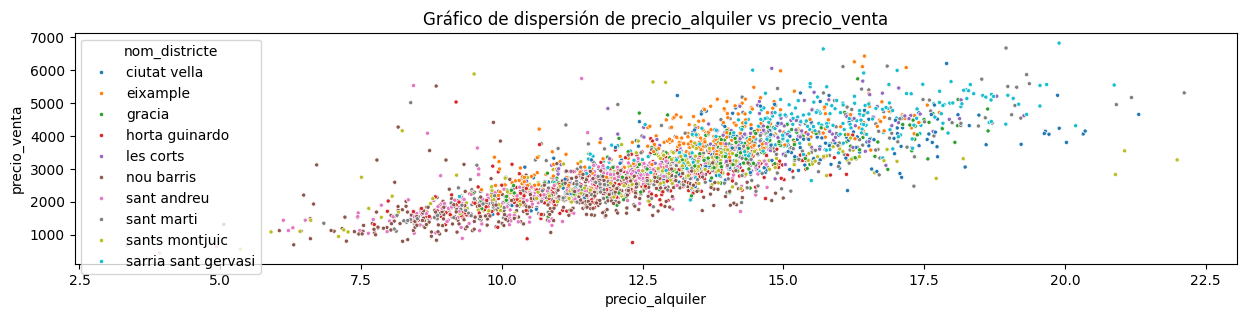

Gráfico de dispersión de precio_alquiler vs codi_districte


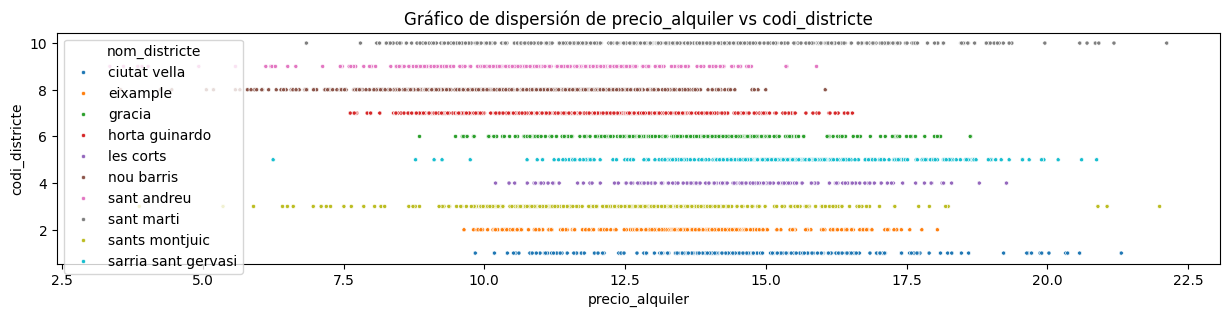

Gráfico de dispersión de precio_alquiler vs codi_barri


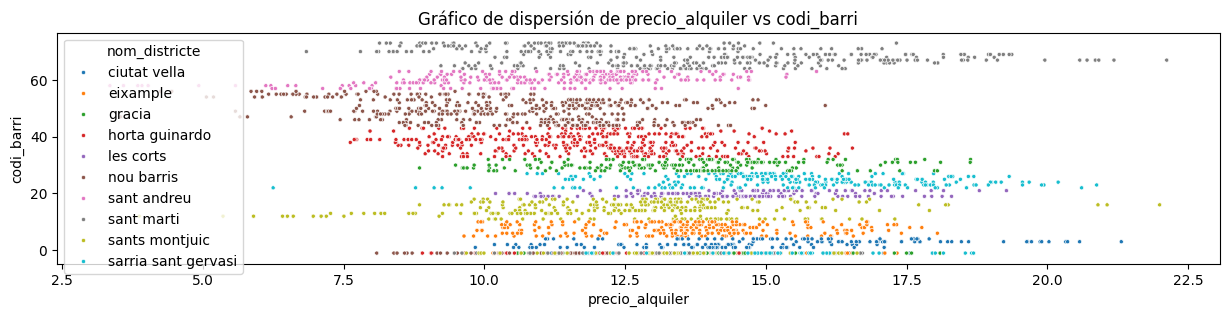

Gráfico de dispersión de precio_venta vs codi_districte


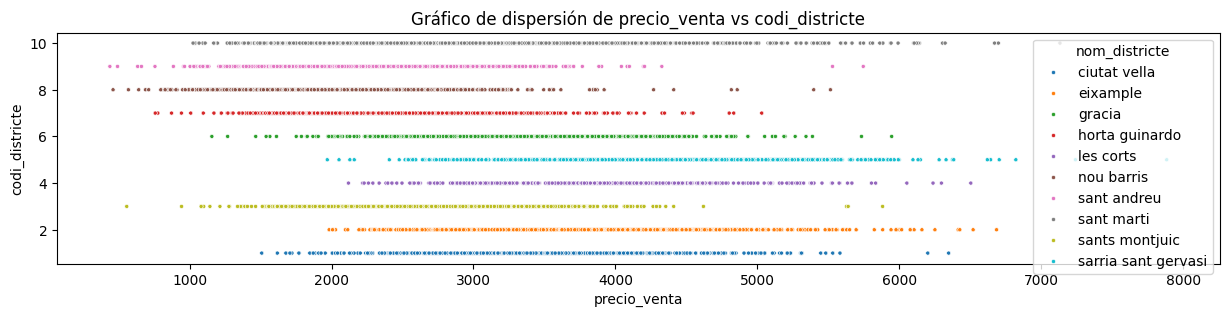

Gráfico de dispersión de precio_venta vs codi_barri


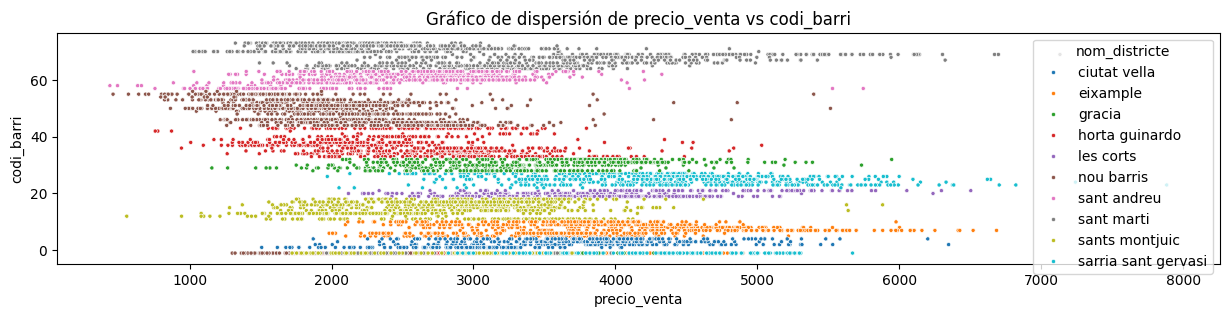

Gráfico de dispersión de codi_districte vs codi_barri


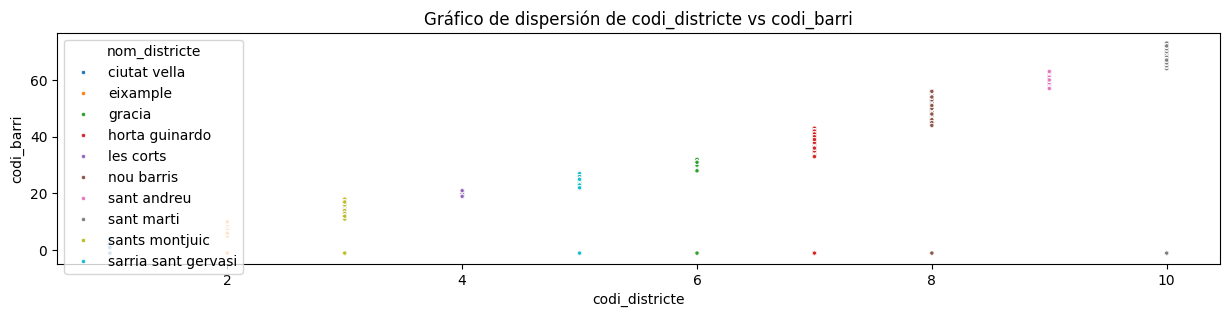

In [47]:
import itertools

# Genera gráficos de dispersión para todas las combinaciones de columnas numéricas

columnas_numericas=bcn_precios.describe().columns.tolist()

for c1, c2 in itertools.combinations(columnas_numericas, 2):
    print(f'Gráfico de dispersión de {c1} vs {c2}')
    fig = plt.figure(figsize=(15, 3))
    plt.title(f'Gráfico de dispersión de {c1} vs {c2}')
    if bcn_precios[c1].dtype.kind != 'M' and bcn_precios[c2].dtype.kind == 'M':
        t = c1
        c1 = c2
        c2 = t
    sns.scatterplot(data=bcn_precios, x=c1, y=c2, marker='.', hue='nom_districte')
    # if bcn_precios[c1].dtype.kind != 'M' and bcn_precios[c2].dtype.kind != 'M':
    #     z = np.polyfit(bcn_precios[c1].dropna(subset=[c1,c2]), bcn_precios[c2].dropna(subset=[c1,c2]), 1)
    #     p = np.poly1d(z)
    #     plt.plot(bcn_precios[c1],p(bcn_precios[c1]),"r--")
    #     # plt.hexbin(bcn_precios=bcn_precios, x=c1, y=c2, gridsize=30, cmap='Blues')

    plt.show()

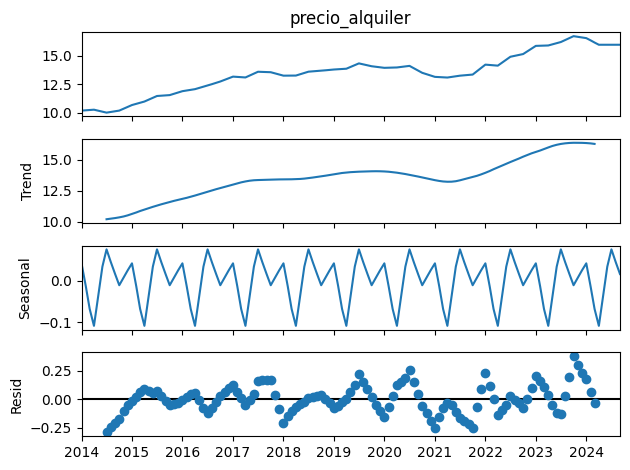

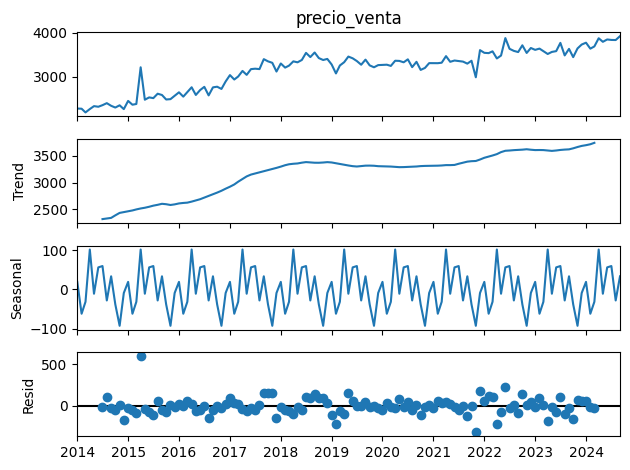

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de series temporales para cada columna numérica individual
for c in ['precio_alquiler', 'precio_venta']:
    df = bcn_precios[bcn_precios['nombre'] == 'barcelona'].interpolate().set_index('mes')[c]
    seasonal_decompose(df).plot()

    plt.show()
 

## Análisis de cohotes

### **Descripción de la cohorte `cohortes_distrito`**

La cohorte `cohortes_distrito` se genera a partir de los datos del dataset agrupados por **distrito** (`codi_districte`) y **año** (`año`), con el objetivo de analizar las tendencias de los precios de alquiler y venta en diferentes distritos de Barcelona a lo largo del tiempo.

#### **Estructura de la cohorte `cohortes_distrito`**

1. **Identificador de cohorte**: La cohorte se define como la combinación del `codi_districte` (que representa el distrito de la ciudad) y el `año` de la fecha del dato (`mes` transformado en año). Así, cada fila del DataFrame representa un distrito y el año de las mediciones de precios, lo que permite observar cómo han evolucionado los precios de alquiler y venta en ese distrito a lo largo del tiempo.
   
   - **Cohorte**: `cohorte_distrito = codi_districte + '-' + año`

2. **Variables principales**:
   - **`alquiler_medio`**: Precio medio de alquiler en ese distrito y año.
   - **`venta_media`**: Precio medio de venta en ese distrito y año.
   - **`codi_districte`**: Código del distrito, que se usa para identificar el área específica de Barcelona.
   - **`año`**: El año de la medición, extraído de la columna `mes`.

#### **Ejemplo de una fila en `cohortes_distrito`**:

| cohorte_distrito | alquiler_medio | venta_media | codi_districte | año |
|------------------|----------------|-------------|----------------|-----|
| 9-2014           | 3.92           | 438.5       | 9              | 2014|
| 9-2015           | 4.10           | 450.0       | 9              | 2015|
| 9-2016           | 4.05           | 460.0       | 9              | 2016|

En este ejemplo:
- El distrito con `codi_districte = 9` (Sant Andreu) se agrupa en las cohortes correspondientes a los años 2014, 2015 y 2016. Se calcula el precio medio de alquiler y venta en ese distrito para cada uno de esos años.

### **Justificación de la cohorte `cohortes_distrito`**

1. **Análisis geográfico a nivel distrital**:
   - **Diferencias regionales**: Los distritos de Barcelona suelen presentar características socioeconómicas distintas. Algunos pueden ser más turísticos, otros más residenciales o comerciales, lo que afecta tanto a la oferta como a la demanda de propiedades. Al crear una cohorte basada en el distrito y año, se puede observar cómo evoluciona el mercado de precios en diferentes áreas de la ciudad.
   - **Estabilidad local**: El análisis de los precios por distrito permite observar si ciertas zonas experimentan una estabilidad o fluctuaciones a lo largo del tiempo, lo que puede ser valioso para inversores, planificadores urbanos y ciudadanos interesados en las tendencias inmobiliarias.

2. **Evolución temporal de los precios**:
   - Al agrupar los datos por año, es posible identificar si los precios de alquiler y venta en un distrito aumentan, disminuyen o permanecen estables a lo largo del tiempo. Esto puede reflejar factores como la gentrificación, cambios en la infraestructura, o políticas urbanísticas locales.
   - **Estacionalidad**: Además de observar las tendencias anuales, esta cohorte podría ser útil para detectar patrones estacionales si se desglosara aún más en base a meses o trimestres.

3. **Impacto de factores externos**:
   - Las variaciones de los precios en los distritos podrían estar influenciadas por eventos o decisiones fuera del control de los individuos, como el desarrollo de infraestructuras, cambios en las leyes de arrendamiento, o proyectos urbanísticos. Esta cohorte ayuda a estudiar cómo esos factores afectan a cada distrito de manera distinta.

4. **Segmentación para análisis detallados**:
   - La cohorte por distrito permite realizar un análisis más granular, lo que facilita la toma de decisiones específicas para cada zona. Por ejemplo, si un distrito muestra un aumento considerable en los precios, podría ser un indicativo de que la zona está siendo más demandada o que está pasando por un proceso de renovación o desarrollo.
   - Las políticas urbanísticas o el desarrollo económico podrían ser analizados en función de cómo afectan a los diferentes distritos. Si el distrito con un alto índice de precios sube significativamente, se podría investigar si el área está siendo renovada o si tiene un crecimiento económico.

### **Conclusión**
La cohorte `cohortes_distrito` es valiosa porque permite hacer un análisis detallado de la evolución de los precios inmobiliarios en Barcelona, proporcionando información útil tanto para analistas de datos como para los responsables de la toma de decisiones en planificación urbana, inversión inmobiliaria y desarrollo económico.

In [66]:

# Crear columnas adicionales para cohortes
bcn_precios['año'] = bcn_precios['mes'].dt.year  # Extraer el año
bcn_precios['cohorte_distrito'] = bcn_precios['nom_districte'] + '-' + bcn_precios['año'].astype(str)  # Cohorte distrito-año
bcn_precios['cohorte_barrio'] = bcn_precios[bcn_precios['tipo'] == 'barri']['nombre'] + '-' + bcn_precios['año'].astype(str)  # Cohorte barrio-año

# Cálculo de métricas por cohorte
cohortes_distrito = bcn_precios.groupby('cohorte_distrito').agg({
    'precio_alquiler': 'mean',
    'precio_venta': 'mean',
    'nom_districte': 'first',  # Opcional: mantener información adicional
    'año': 'first'  # Año para referencias
}).reset_index()

cohortes_barrio = bcn_precios.groupby('cohorte_barrio').agg({
    'precio_alquiler': 'mean',
    'precio_venta': 'mean',
    'nombre': 'first',  # Opcional: mantener información adicional
    'año': 'first'
}).reset_index()

# Opcional: Renombrar columnas para claridad
cohortes_distrito.rename(columns={
    'precio_alquiler': 'alquiler_medio',
    'precio_venta': 'venta_media'
}, inplace=True)

cohortes_barrio.rename(columns={
    'precio_alquiler': 'alquiler_medio',
    'precio_venta': 'venta_media'
}, inplace=True)

display("Cohortes por distrito:", cohortes_distrito)
display("Cohortes por barrio:", cohortes_barrio)


'Cohortes por distrito:'

cohorte_distrito  alquiler_medio  venta_media  \
0           ciutat vella-2014       11.771694  2550.350862   
1           ciutat vella-2015       12.854582  2782.686544   
2           ciutat vella-2016       14.358238  3153.632160   
3           ciutat vella-2017       15.855594  3690.912594   
4           ciutat vella-2018       14.866027  4020.173417   
..                        ...             ...          ...   
105  sarria sant gervasi-2020       15.359472  4360.535097   
106  sarria sant gervasi-2021       14.990403  4530.758239   
107  sarria sant gervasi-2022       16.313313  4813.365867   
108  sarria sant gervasi-2023       17.932306  5026.527682   
109  sarria sant gervasi-2024       18.197411  5220.543259   

           nom_districte   año  
0           ciutat vella  2014  
1           ciutat vella  2015  
2           ciutat vella  2016  
3           ciutat vella  2017  
4           ciutat vella  2018  
..                   ...   ...  
105  sarria sant gervasi  2020  
106  sarria sant gervasi  2021  
107  sarria sant gervasi  2022  
108  sarria sant gervasi  2023  
109  sarria sant gervasi  2024  

[110 rows x 5 columns]

'Cohortes por barrio:'

cohorte_barrio  alquiler_medio  venta_media  \
0                    baro de viver-2014        3.975000   438.500000   
1                    baro de viver-2015        4.700881   634.307692   
2                    baro de viver-2016        3.598572   576.595238   
3                    baro de viver-2017        6.210010  1124.352941   
4                    baro de viver-2018        7.538529  1121.800000   
..                                  ...             ...          ...   
798  vilapicina i la torre llobeta-2020       12.286860  2622.688569   
799  vilapicina i la torre llobeta-2021       11.579680  2869.053278   
800  vilapicina i la torre llobeta-2022       12.824563  2848.928197   
801  vilapicina i la torre llobeta-2023       13.755963  2992.058329   
802  vilapicina i la torre llobeta-2024       14.265926  3278.791269   

                            nombre   año  
0                    baro de viver  2014  
1                    baro de viver  2015  
2                    baro de viver  2016  
3                    baro de viver  2017  
4                    baro de viver  2018  
..                             ...   ...  
798  vilapicina i la torre llobeta  2020  
799  vilapicina i la torre llobeta  2021  
800  vilapicina i la torre llobeta  2022  
801  vilapicina i la torre llobeta  2023  
802  vilapicina i la torre llobeta  2024  

[803 rows x 5 columns]

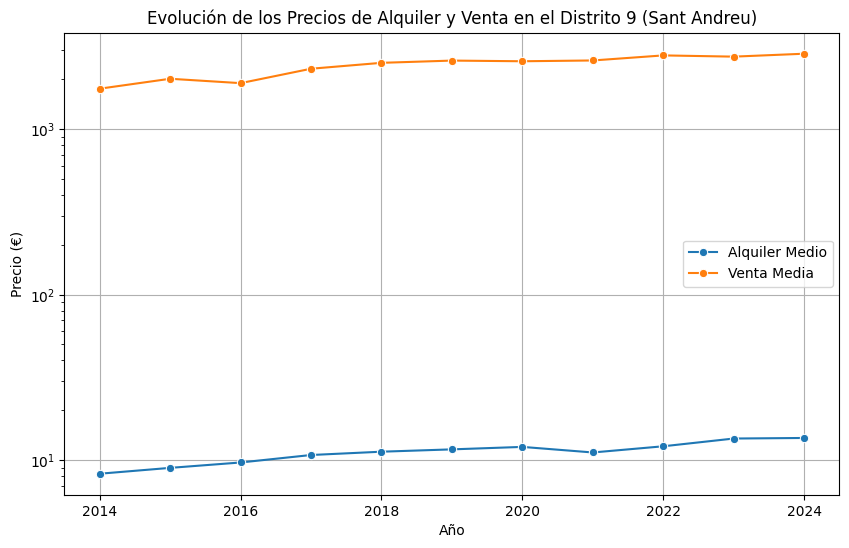

In [77]:
# Filtrar para los primeros distritos (ejemplo)
cohortes_distrito_9 = cohortes_distrito[cohortes_distrito['nom_districte'] == 'sant andreu']

plt.figure(figsize=(10, 6))
sns.lineplot(data=cohortes_distrito_9, x='año', y='alquiler_medio', label='Alquiler Medio', marker='o')
sns.lineplot(data=cohortes_distrito_9, x='año', y='venta_media', label='Venta Media', marker='o')

plt.title("Evolución de los Precios de Alquiler y Venta en el Distrito 9 (Sant Andreu)")
plt.xlabel("Año")
plt.ylabel("Precio (€)")
plt.yscale('log')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

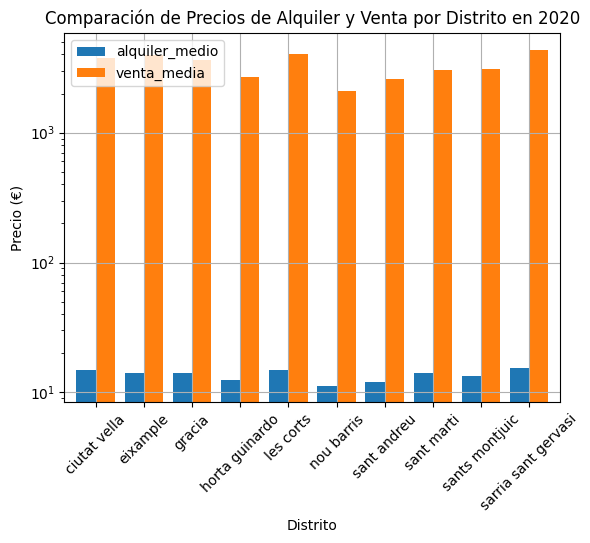

In [69]:
# Filtrar los datos para el año 2020 (por ejemplo)
cohortes_distrito_2020 = cohortes_distrito[cohortes_distrito['año'] == 2020]

plt.figure(figsize=(10, 6))
cohortes_distrito_2020.set_index('nom_districte')[['alquiler_medio', 'venta_media']].plot(kind='bar', width=0.8, logy=True)

plt.title("Comparación de Precios de Alquiler y Venta por Distrito en 2020")
plt.xlabel("Distrito")
plt.ylabel("Precio (€)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


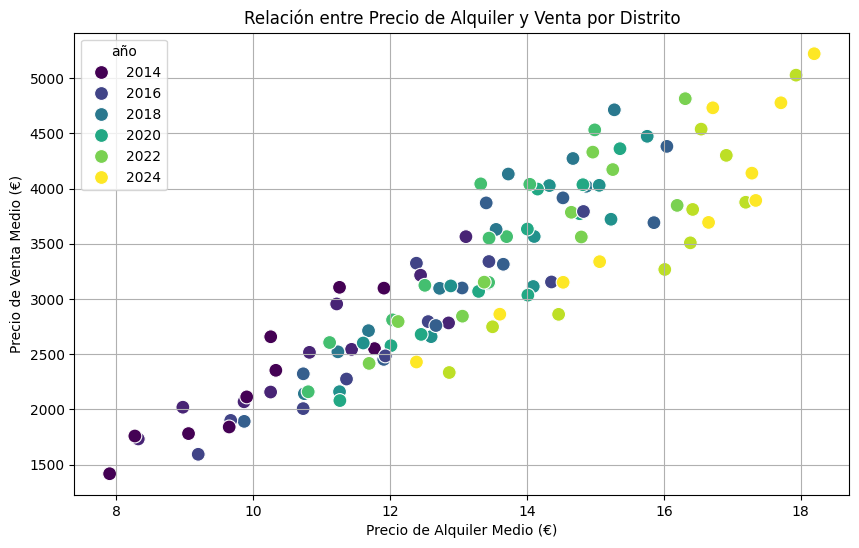

In [70]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cohortes_distrito, x='alquiler_medio', y='venta_media', hue='año', palette='viridis', s=100, marker='o')

plt.title("Relación entre Precio de Alquiler y Venta por Distrito")
plt.xlabel("Precio de Alquiler Medio (€)")
plt.ylabel("Precio de Venta Medio (€)")
plt.grid(True)
plt.show()


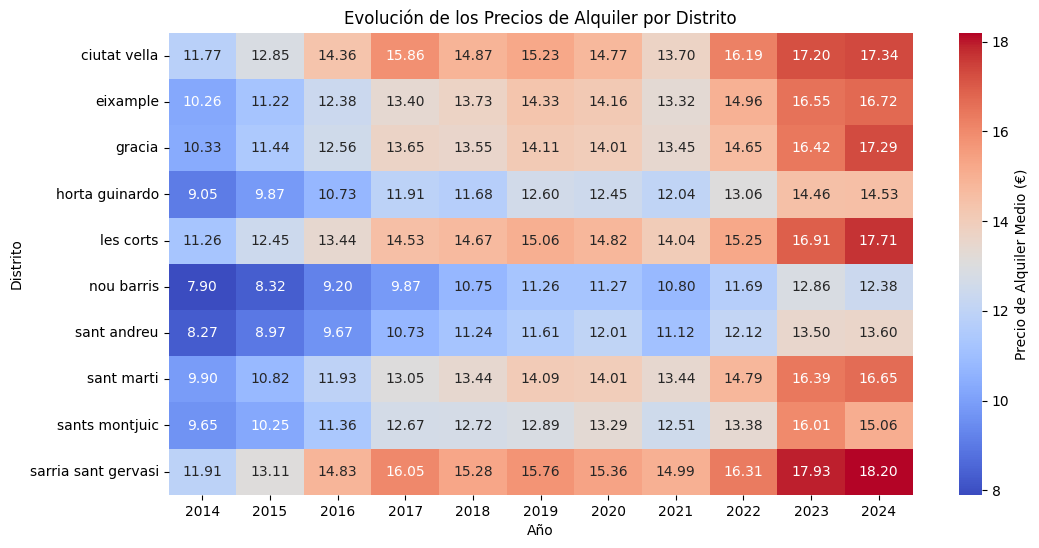

In [71]:
cohortes_distrito_pivot = cohortes_distrito.pivot_table(index='nom_districte', columns='año', values='alquiler_medio')

plt.figure(figsize=(12, 6))
sns.heatmap(cohortes_distrito_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Precio de Alquiler Medio (€)'}, fmt='.2f')

plt.title("Evolución de los Precios de Alquiler por Distrito")
plt.xlabel("Año")
plt.ylabel("Distrito")
plt.show()


<Figure size 1200x600 with 0 Axes>

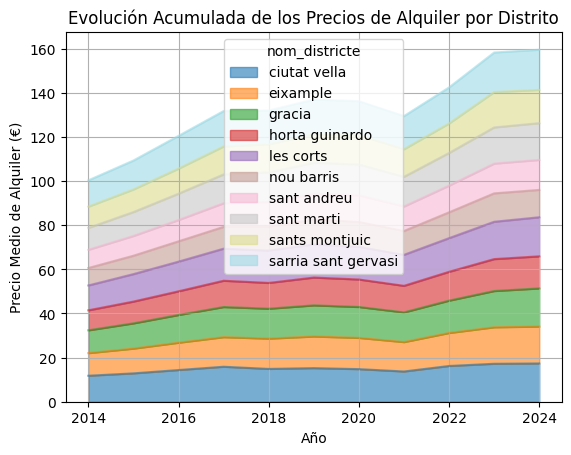

In [74]:
cohortes_distrito_pivot = cohortes_distrito.pivot_table(index='año', columns='nom_districte', values='alquiler_medio')

fig = plt.figure(figsize=(12, 6))
cohortes_distrito_pivot.plot(kind='area', stacked=True, colormap='tab20', alpha=0.6)

plt.title("Evolución Acumulada de los Precios de Alquiler por Distrito")
plt.xlabel("Año")
plt.ylabel("Precio Medio de Alquiler (€)")
fig.legend(title="Distrito", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


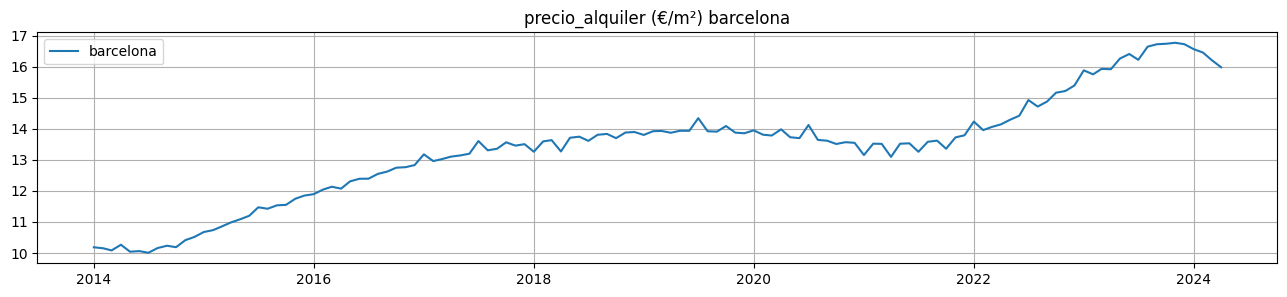

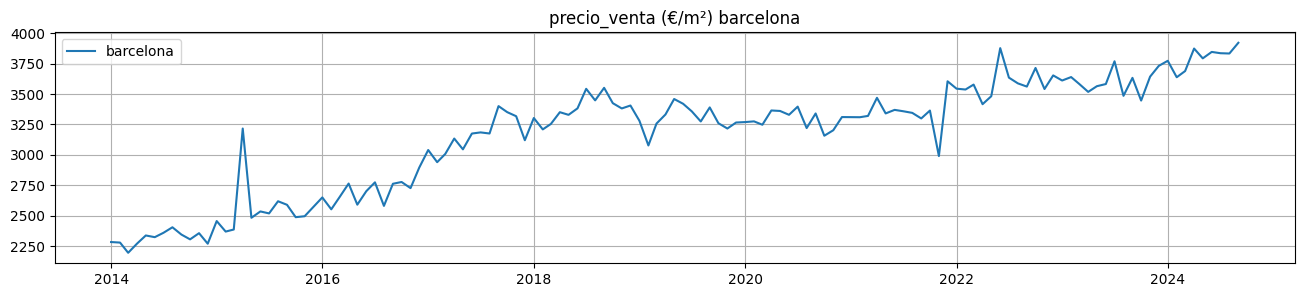

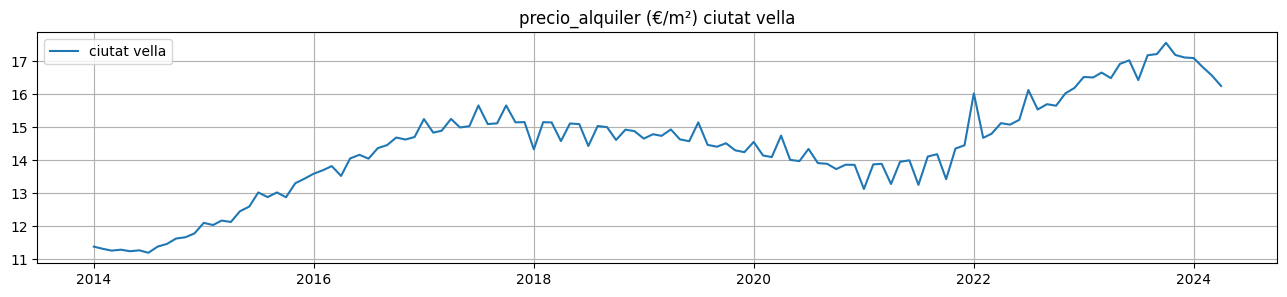

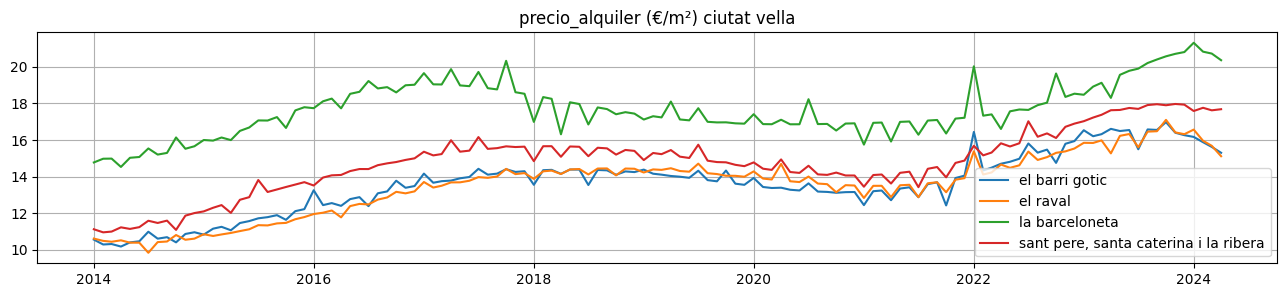

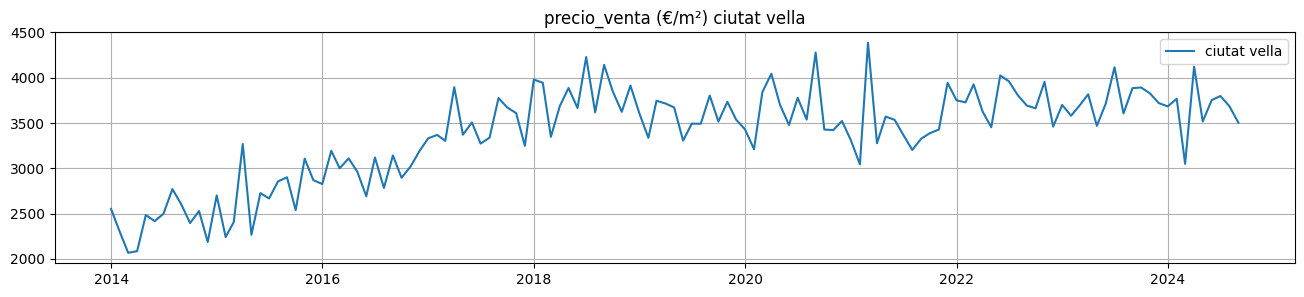

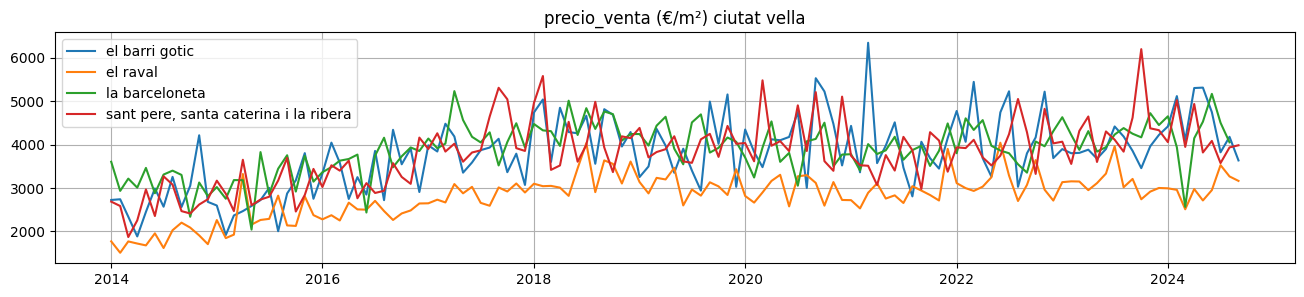

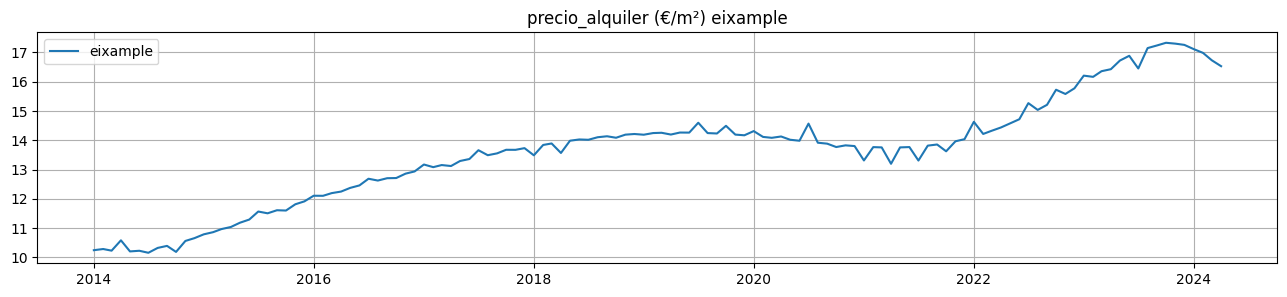

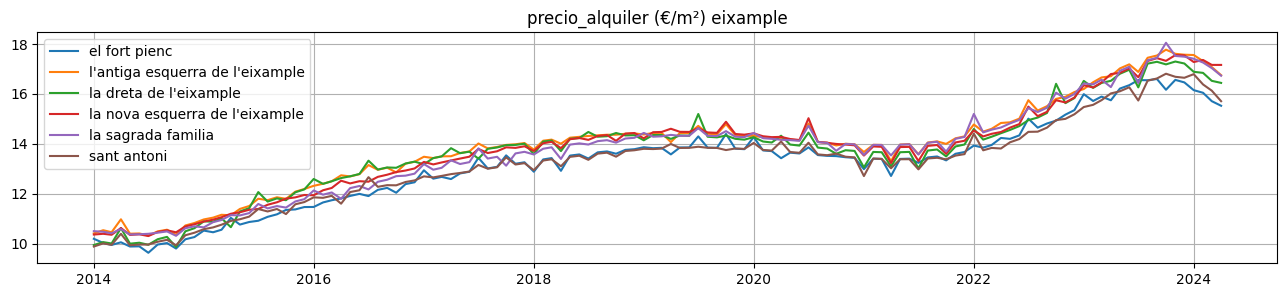

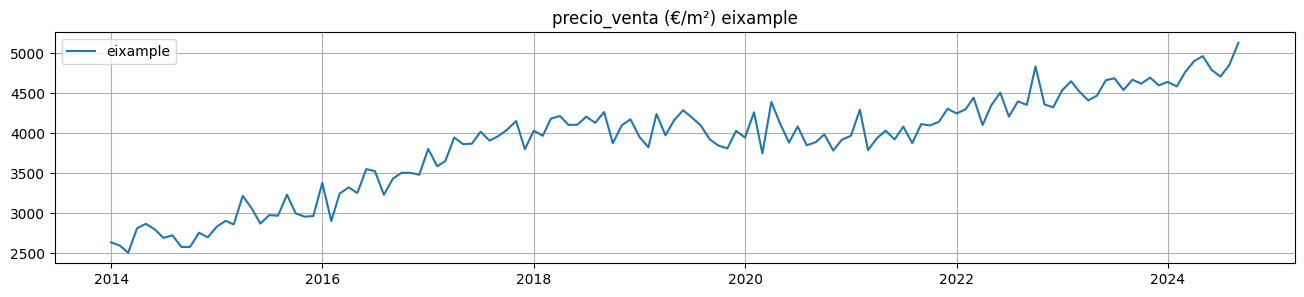

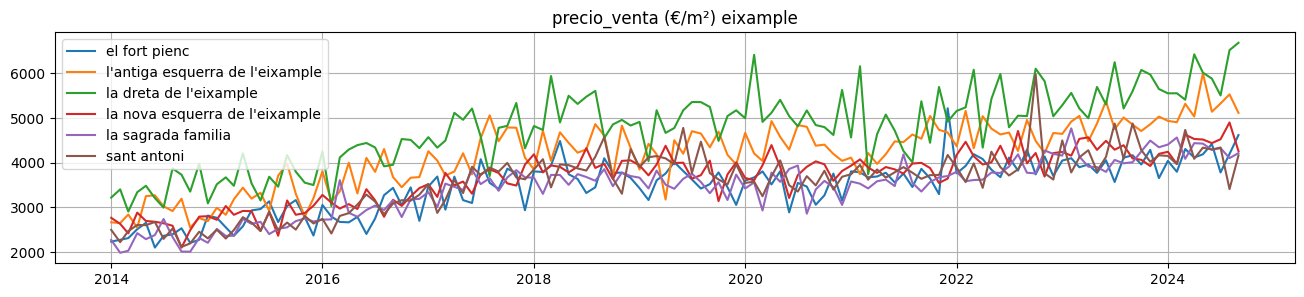

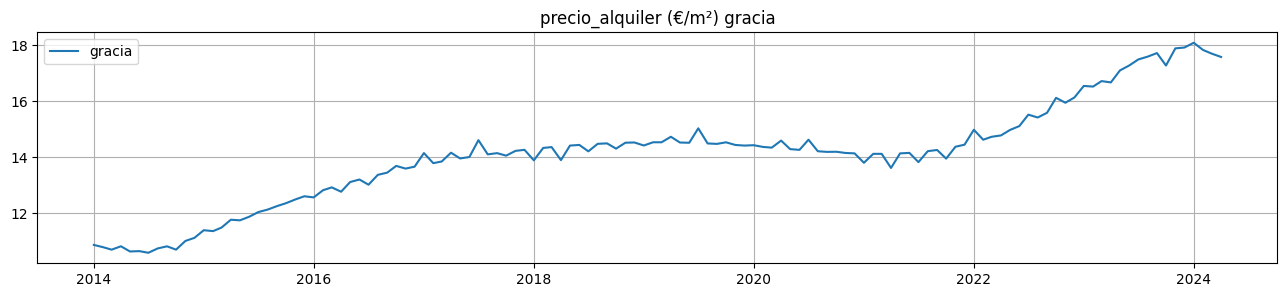

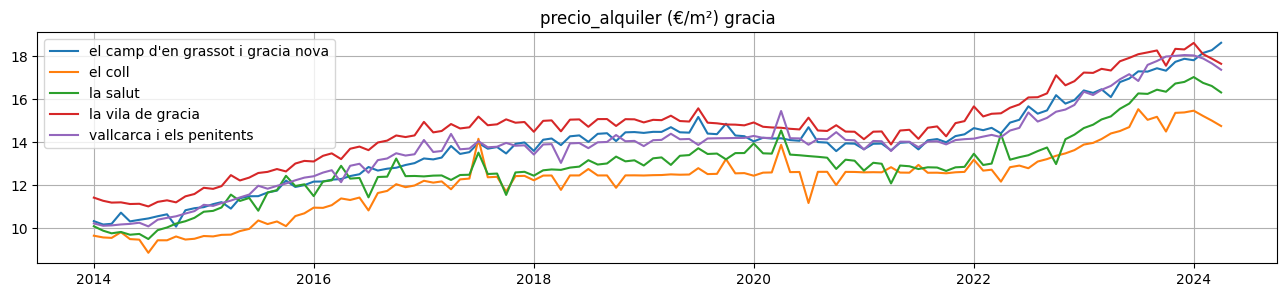

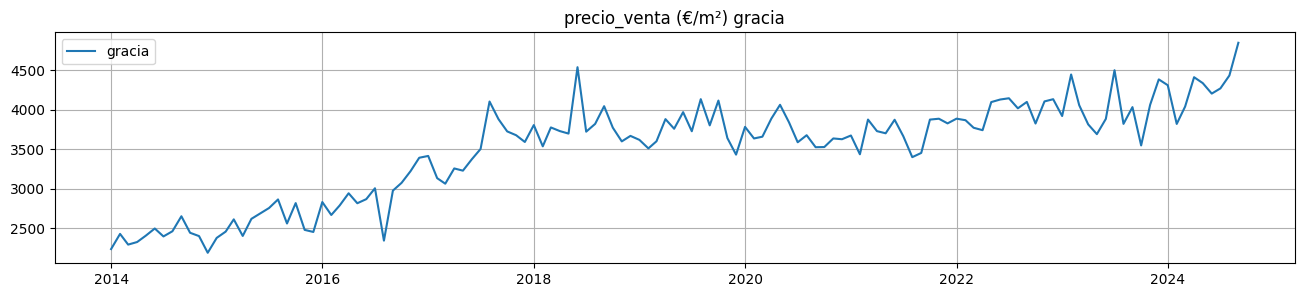

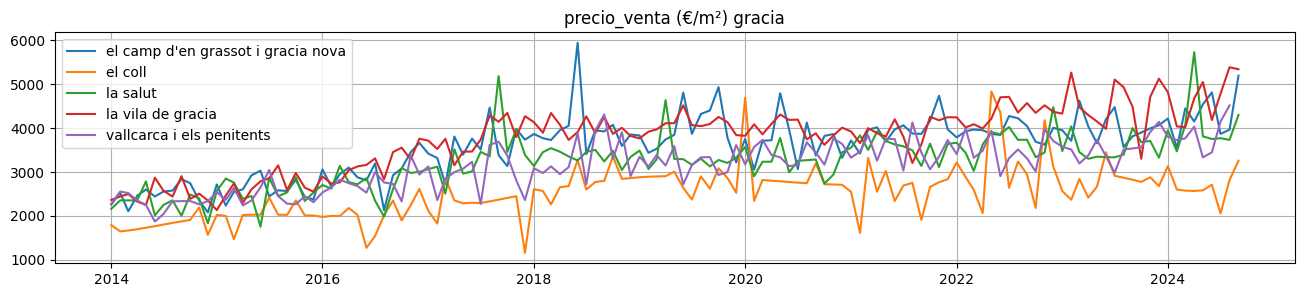

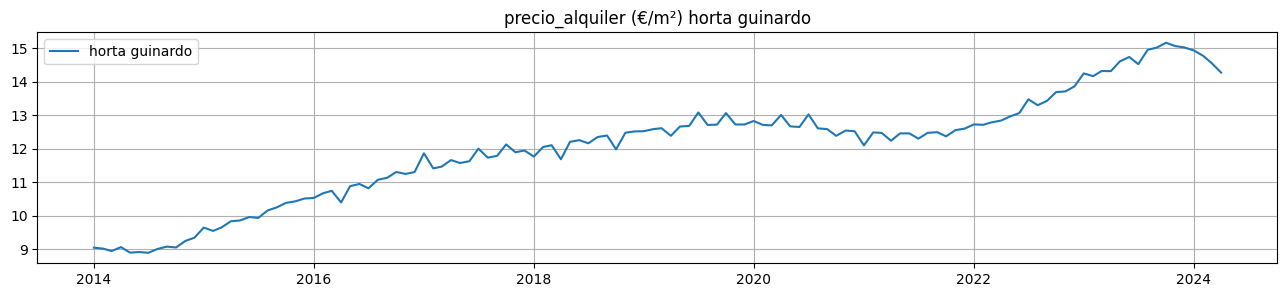

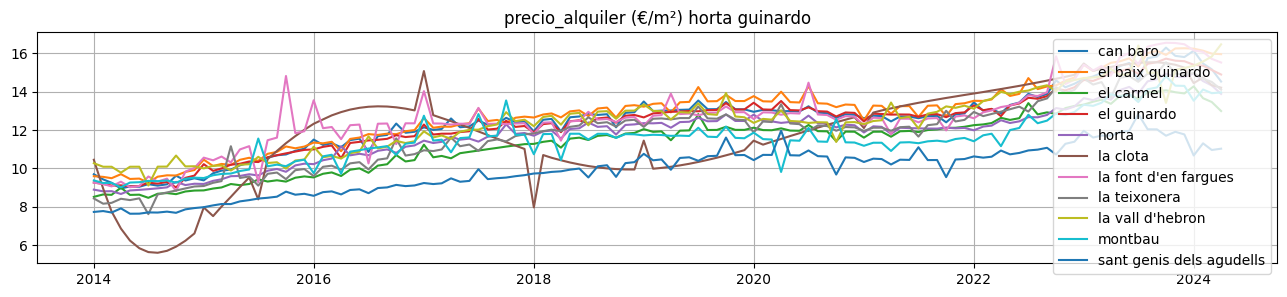

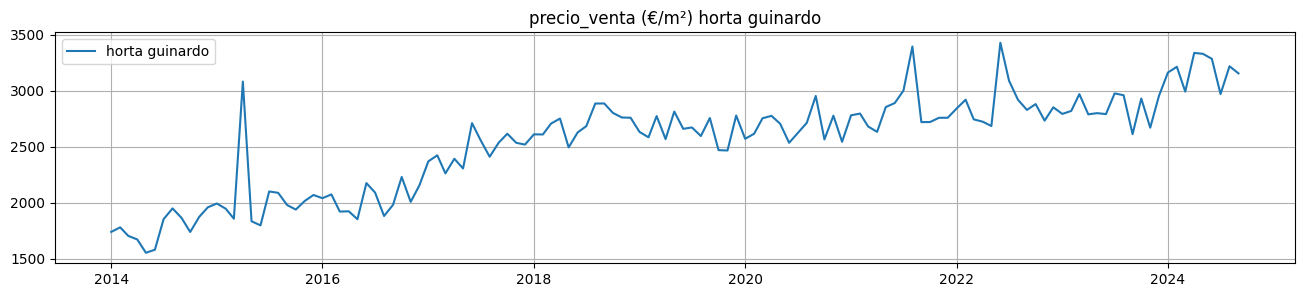

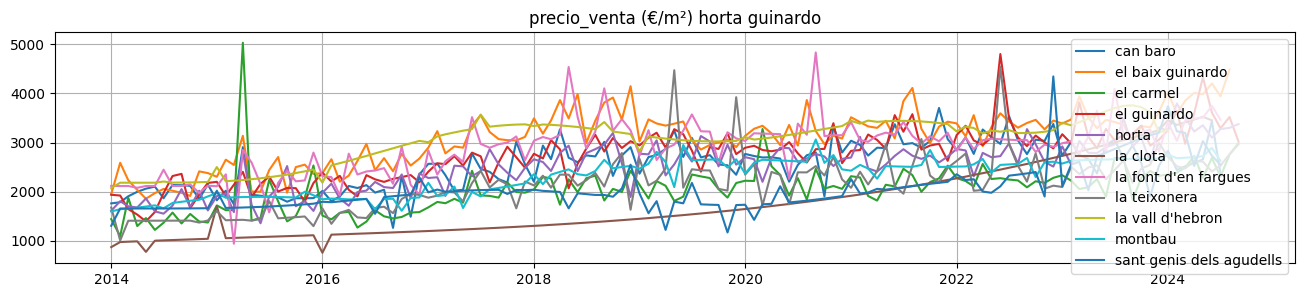

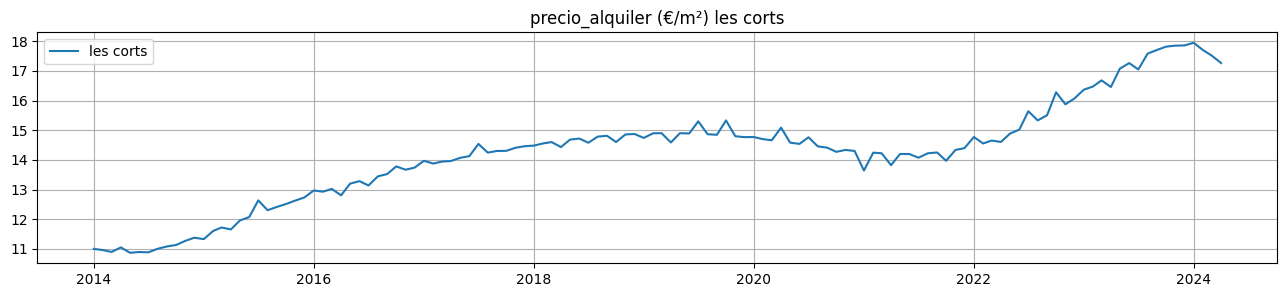

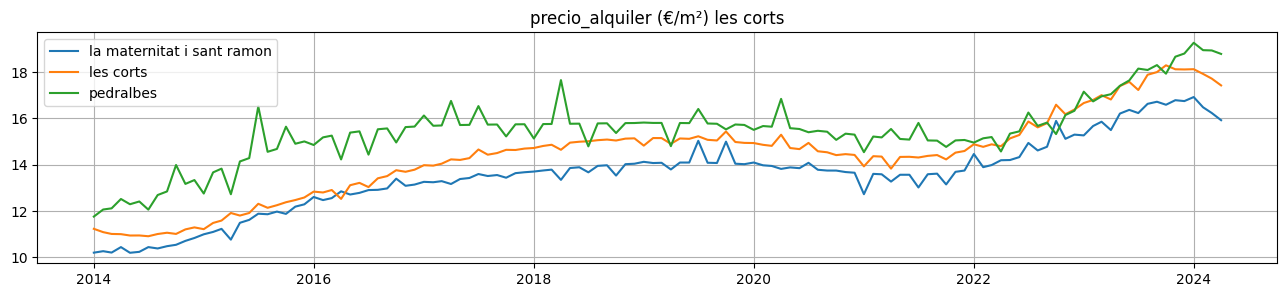

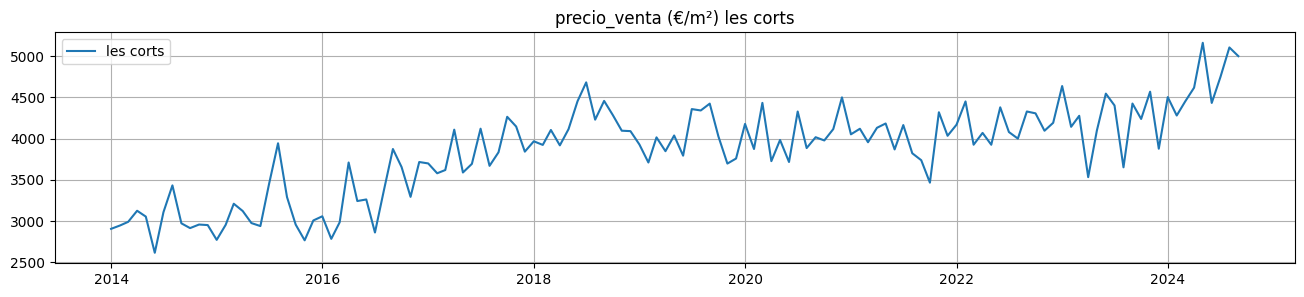

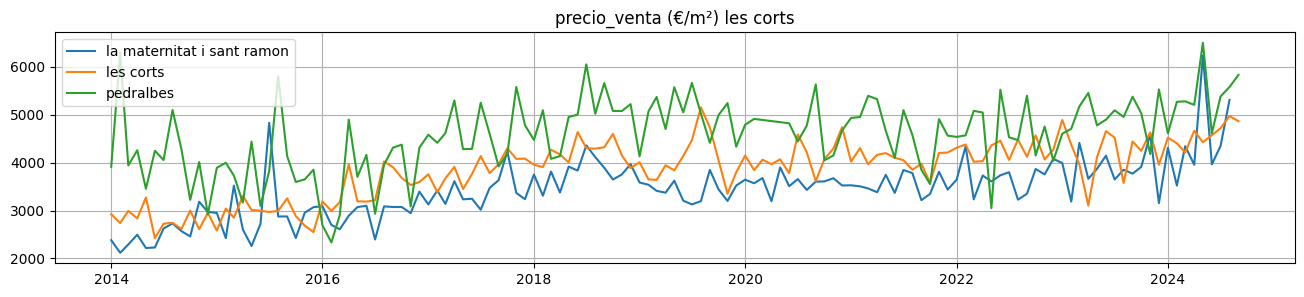

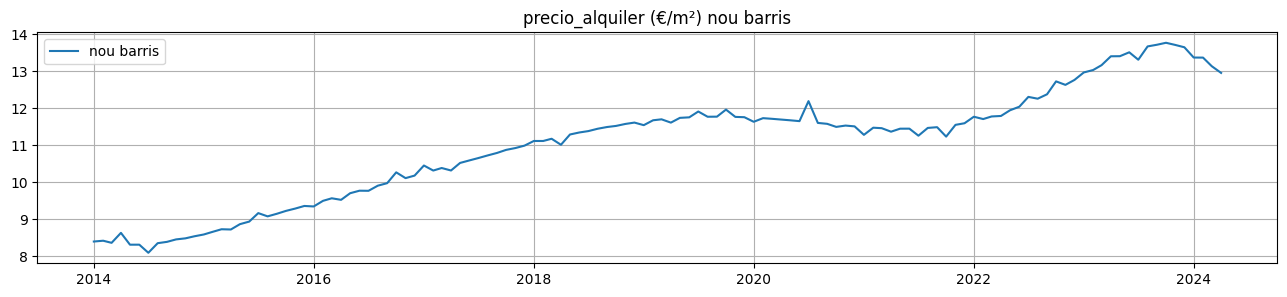

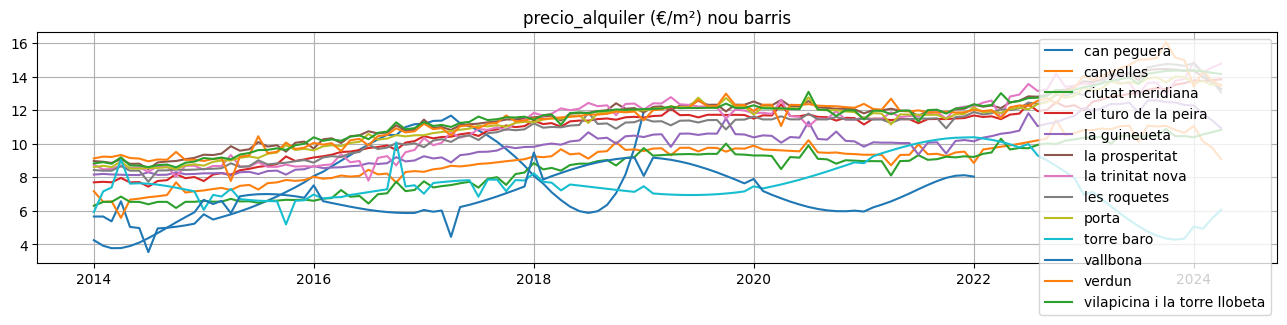

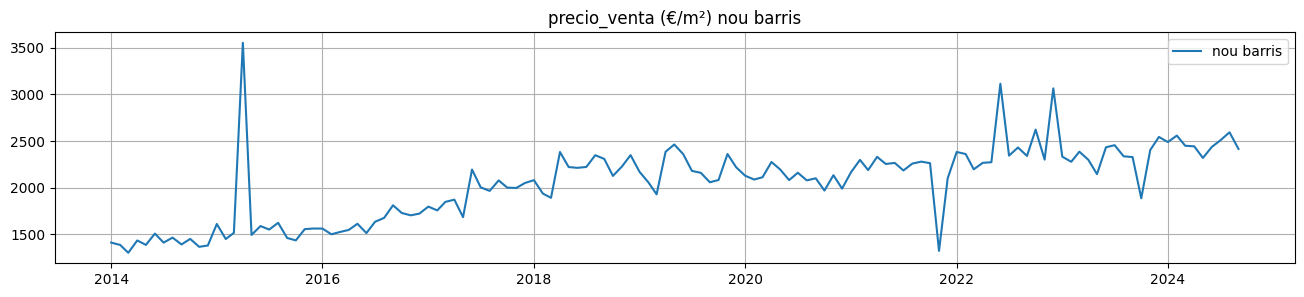

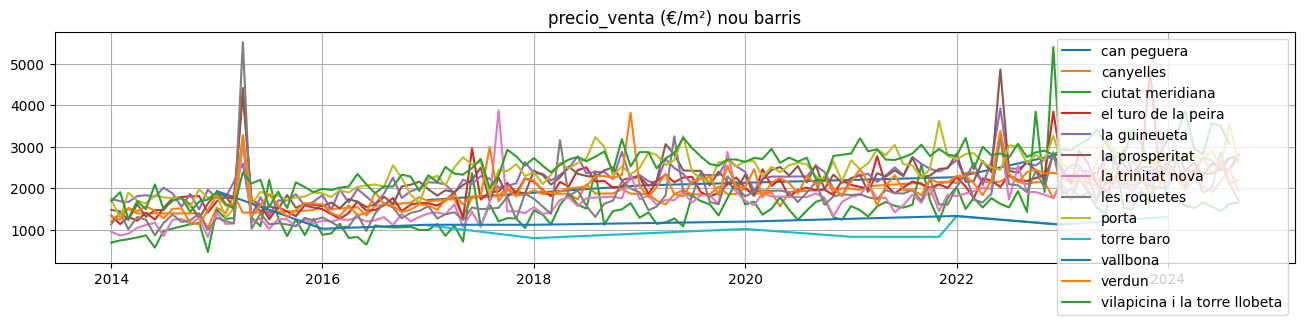

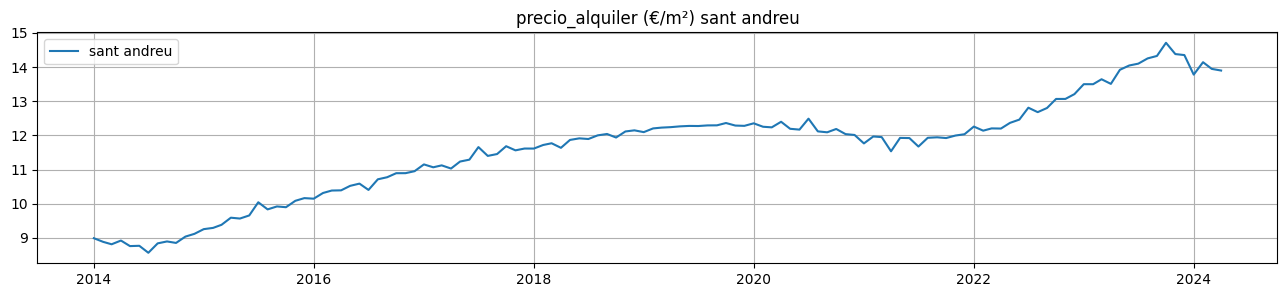

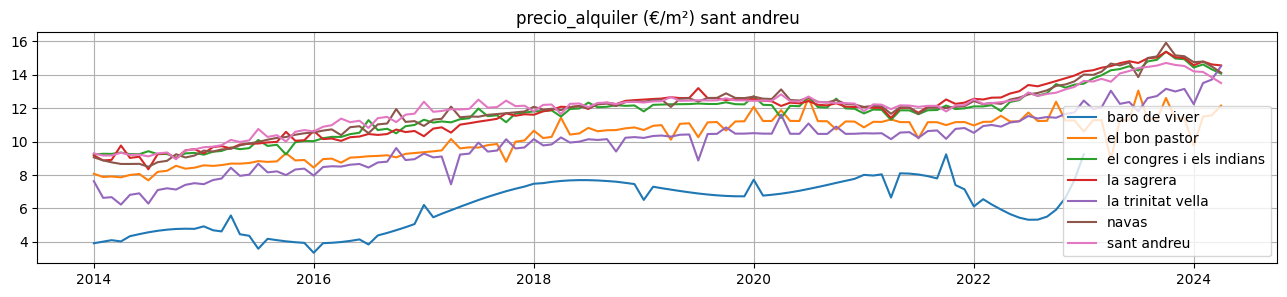

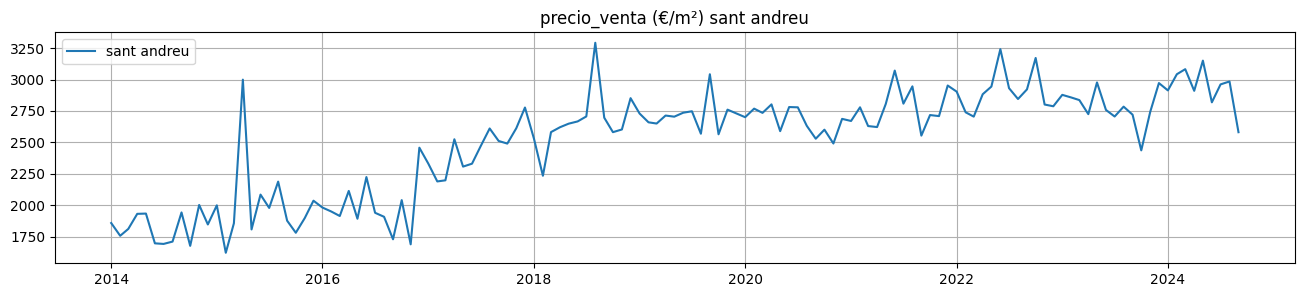

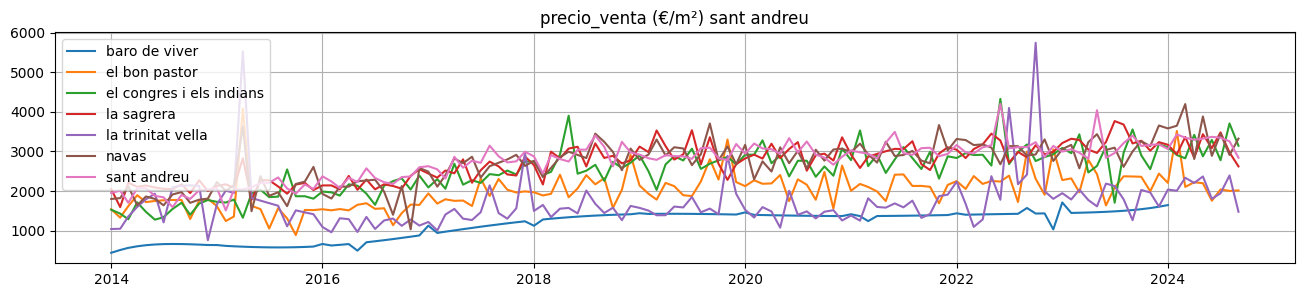

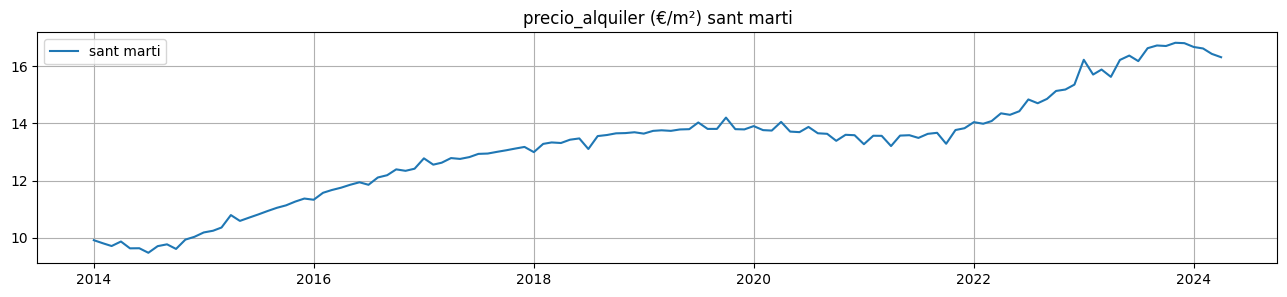

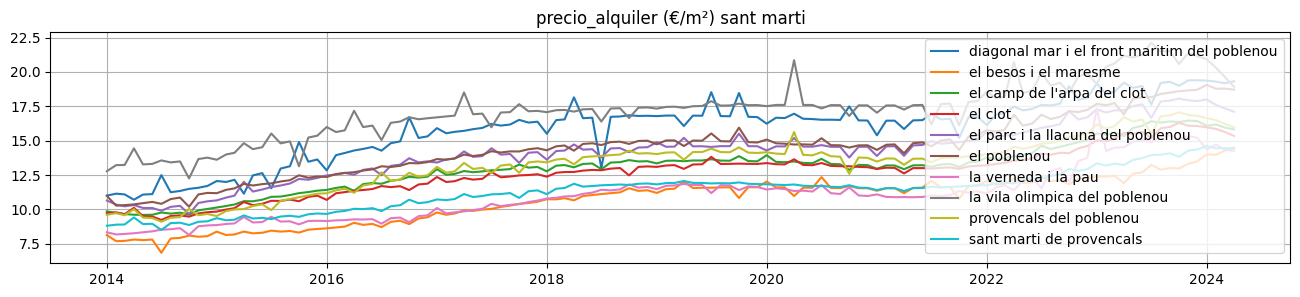

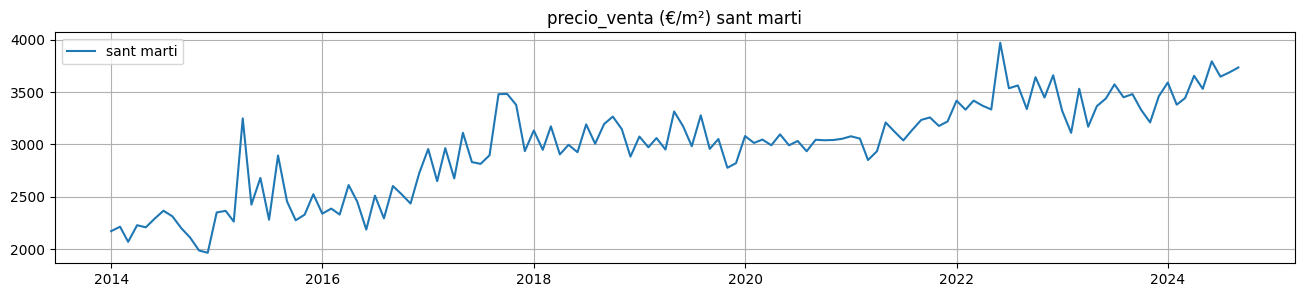

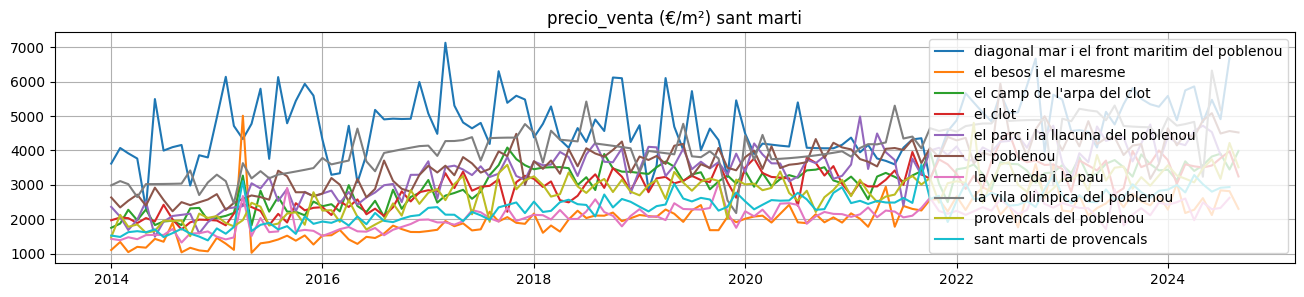

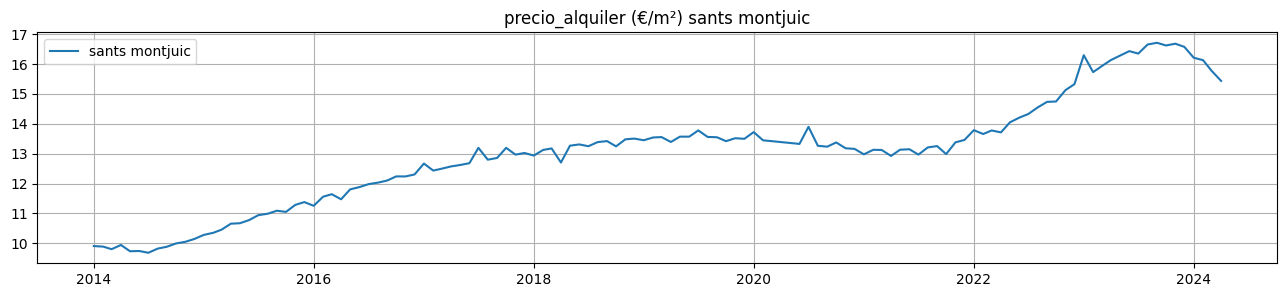

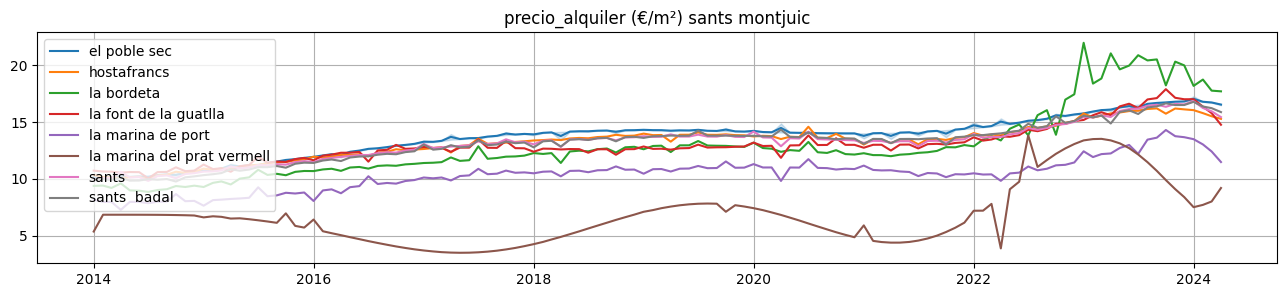

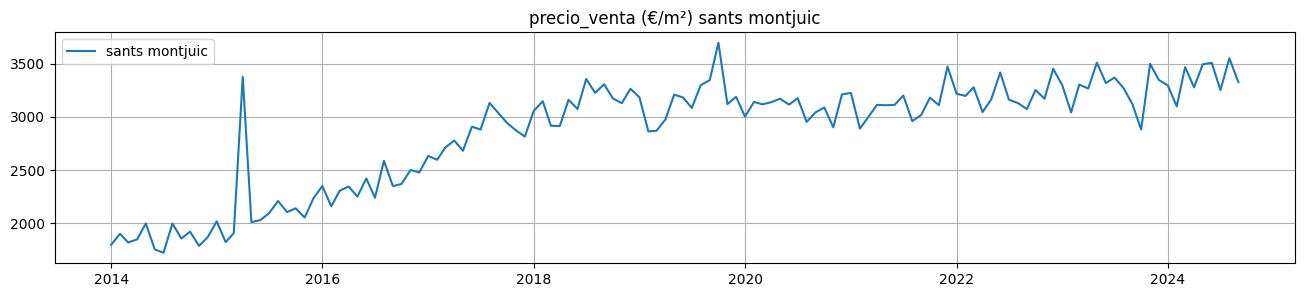

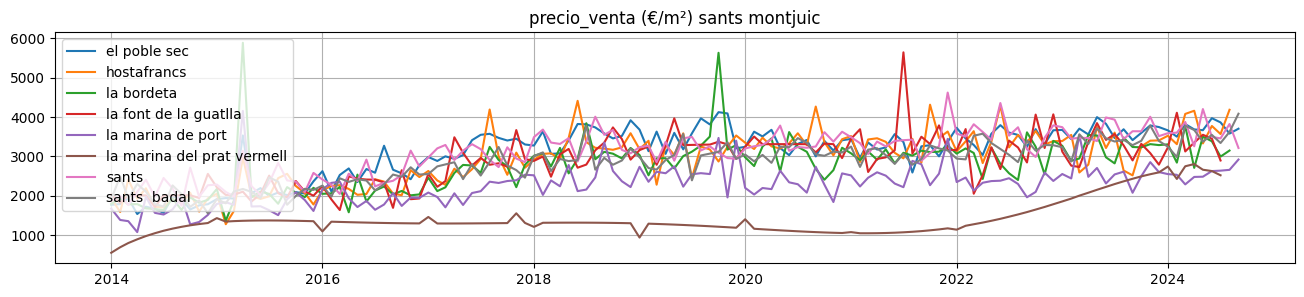

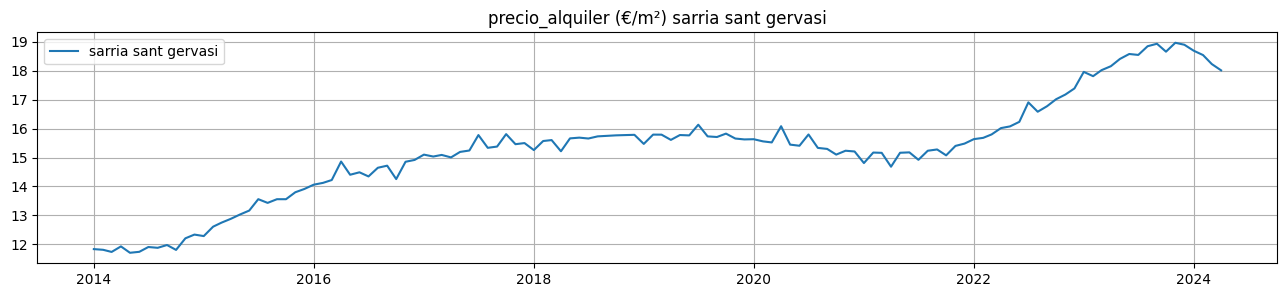

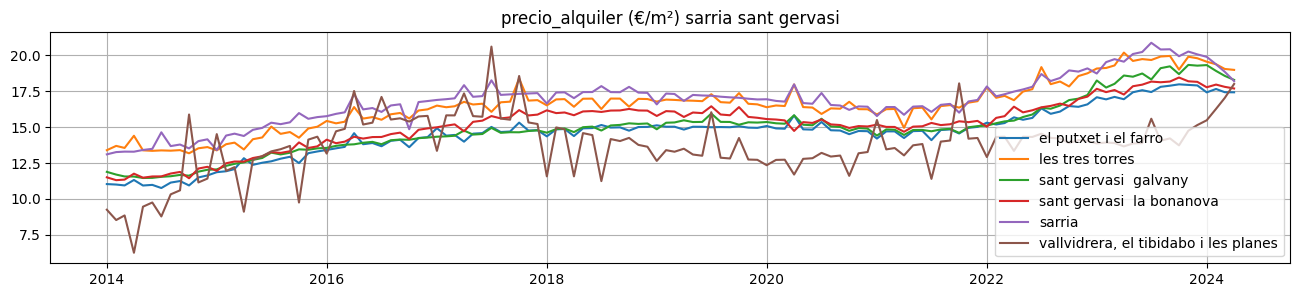

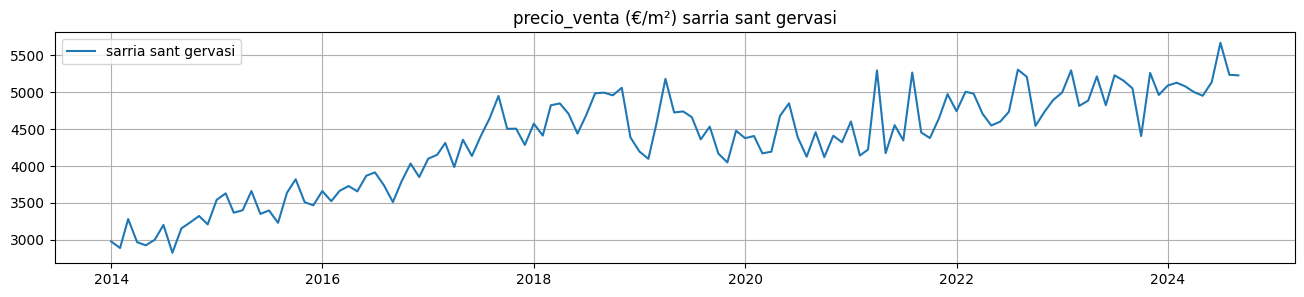

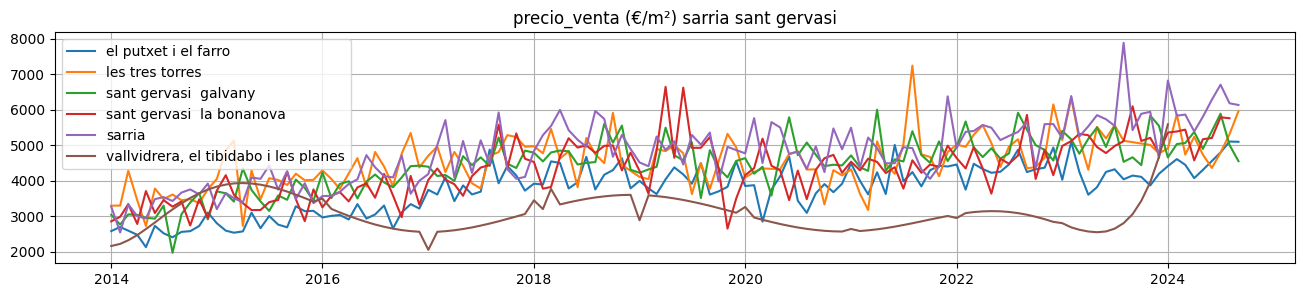

In [55]:
def plot_dist(df, field, figsize=(16, 4), title='', model=None):
    fig = plt.figure(figsize=figsize)
    for c in df['nombre'].unique():
        # sns.scatterplot(x='mes', y=field, data=df[df['nombre'] == c], markers='.')
        sns.lineplot(x='mes', y=field, data=df[df['nombre'] == c], label=c)
        plt.title(f'{field} (€/m²) '+title)
    plt.grid(True)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()


plot_dist(bcn_precios_int[bcn_precios_int['nombre'] == 'barcelona'], 'precio_alquiler',figsize=(16,3), title='barcelona')
plot_dist(bcn_precios_int[bcn_precios_int['nombre'] == 'barcelona'], 'precio_venta',figsize=(16,3), title='barcelona')


for dist in bcn_precios_int['nom_districte'].dropna().unique().tolist():
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'districte')], 'precio_alquiler',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'barri')], 'precio_alquiler',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'districte')], 'precio_venta',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'barri')], 'precio_venta',figsize=(16,3), title=dist)

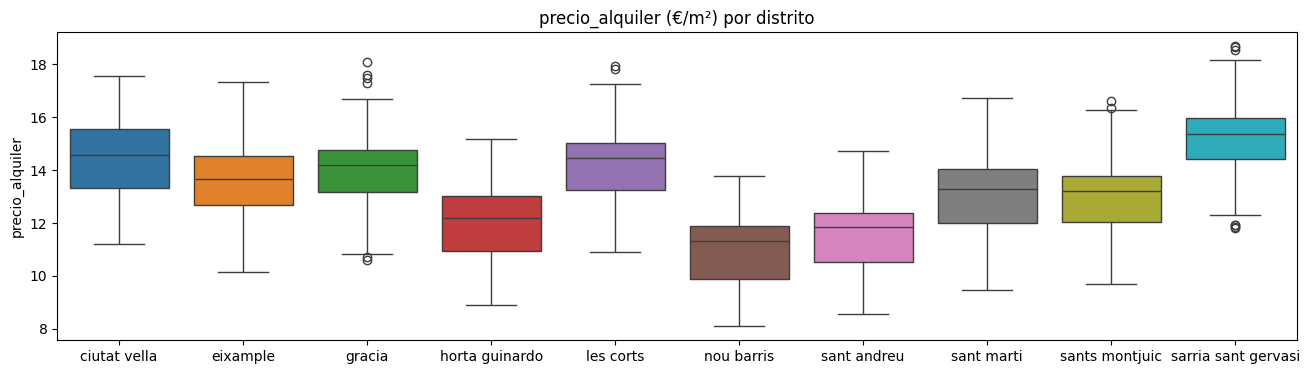

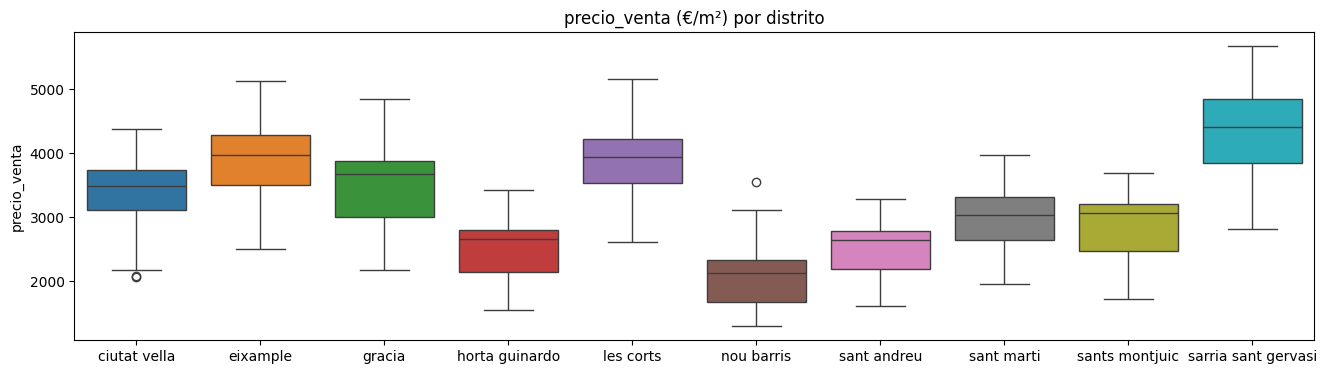

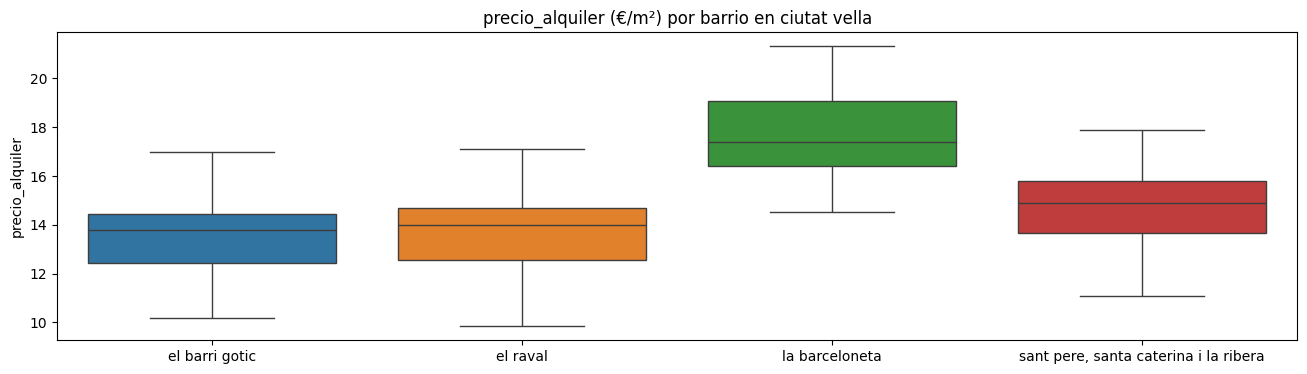

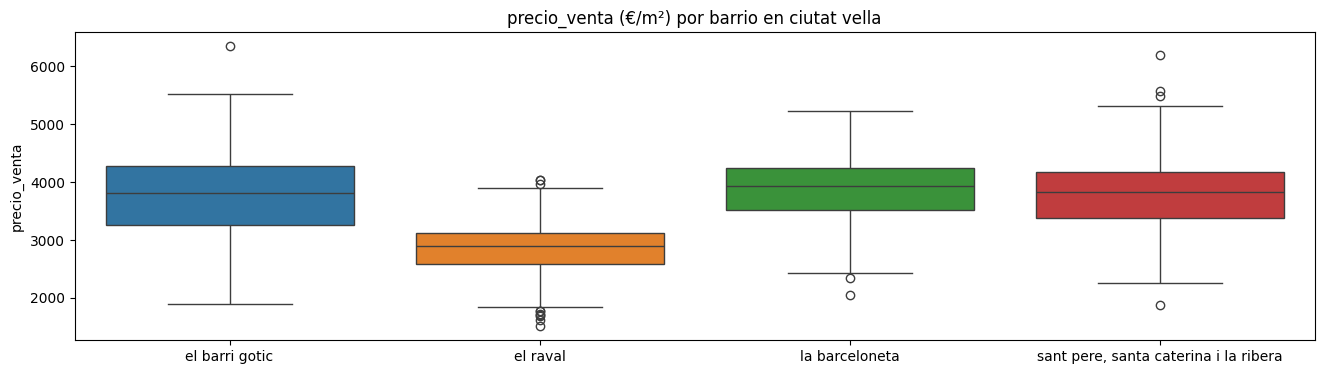

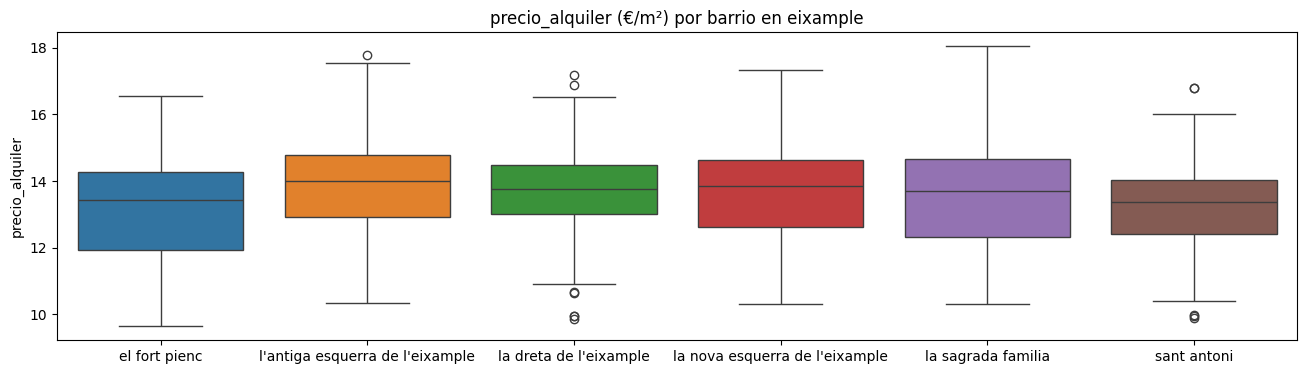

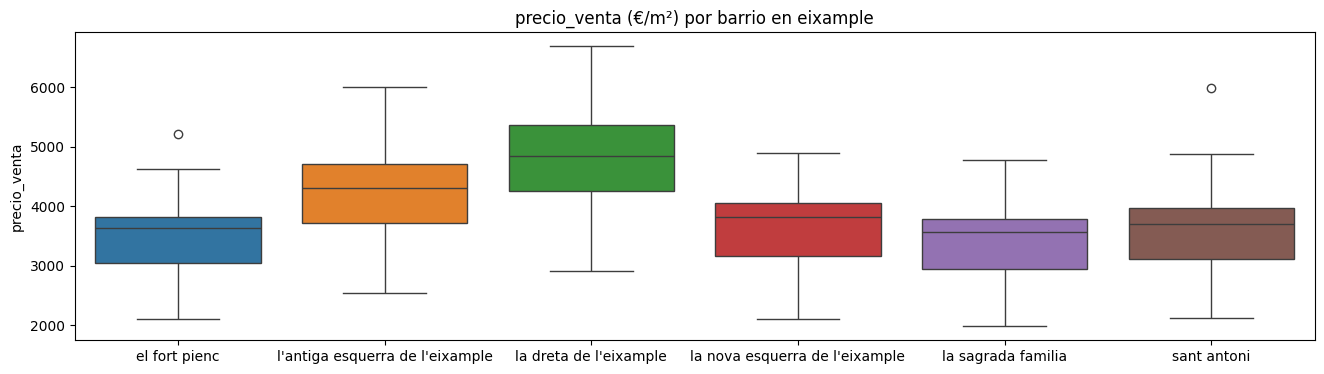

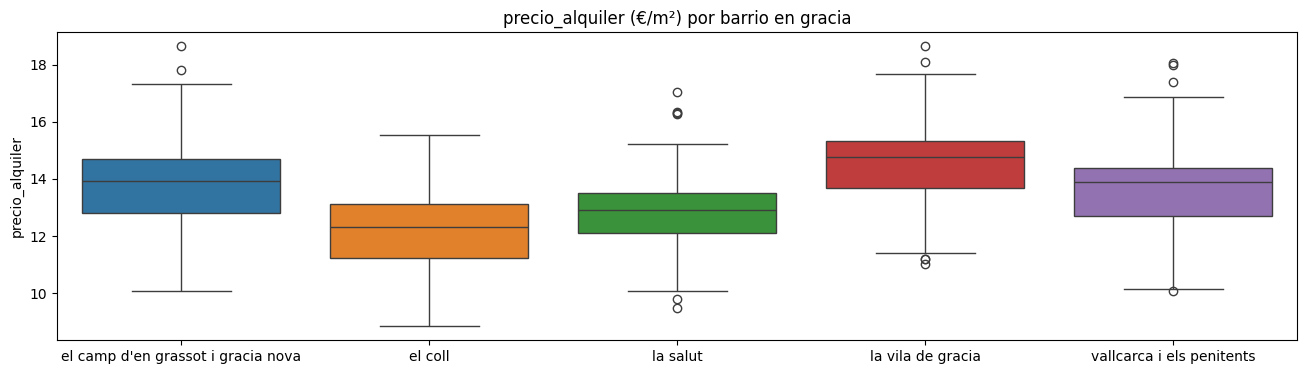

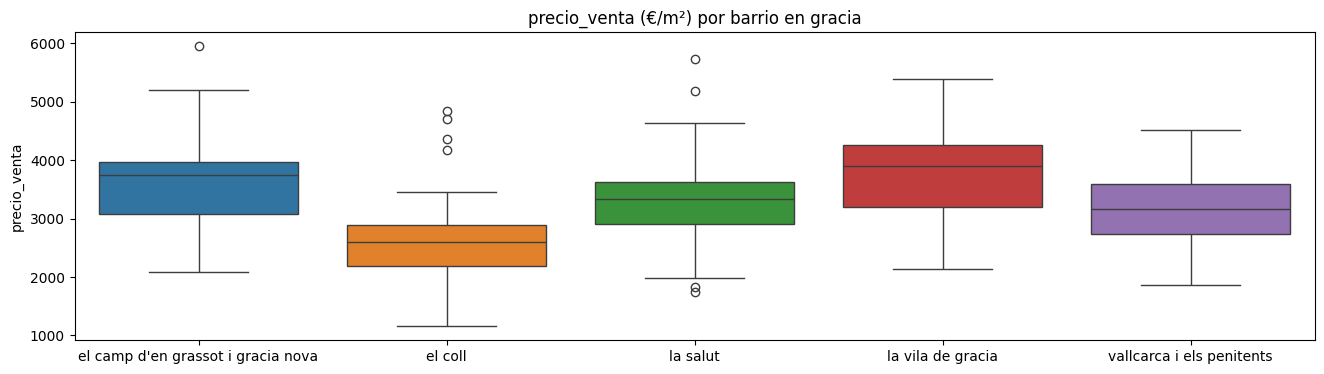

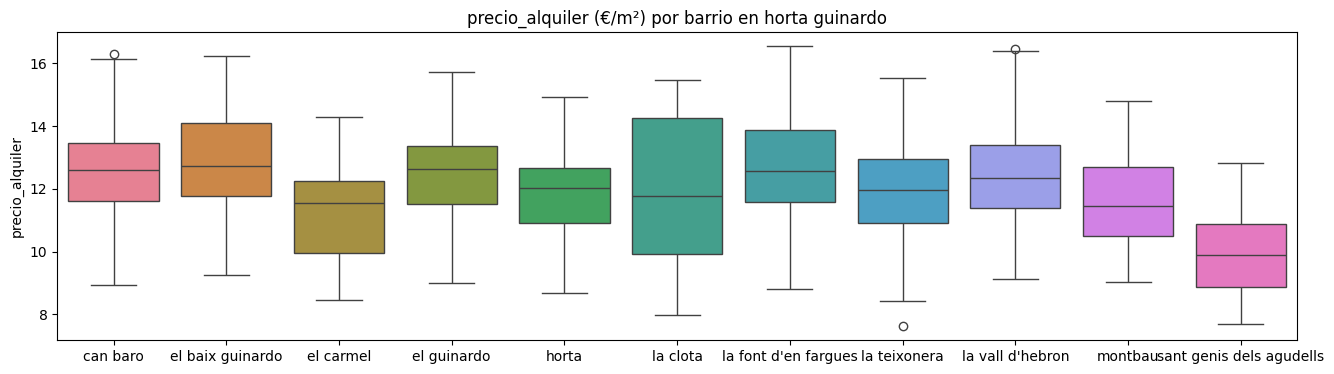

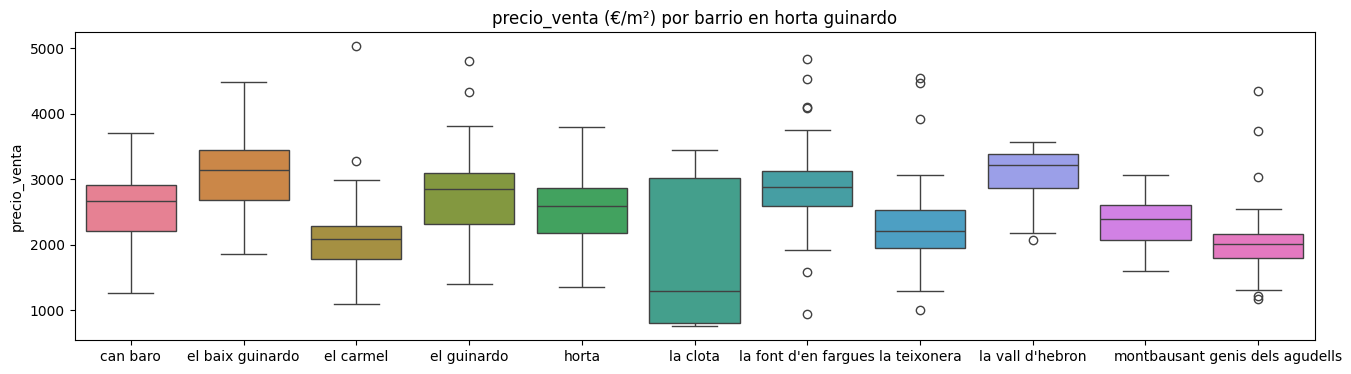

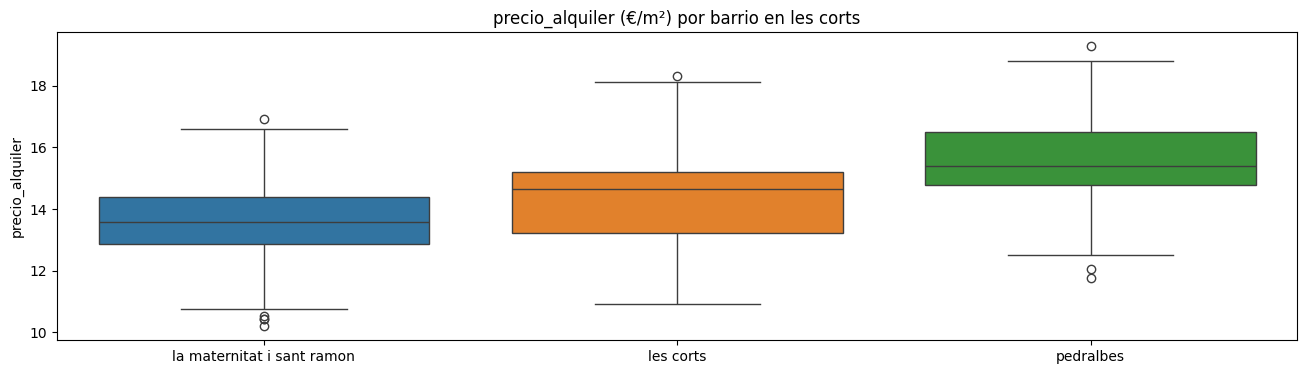

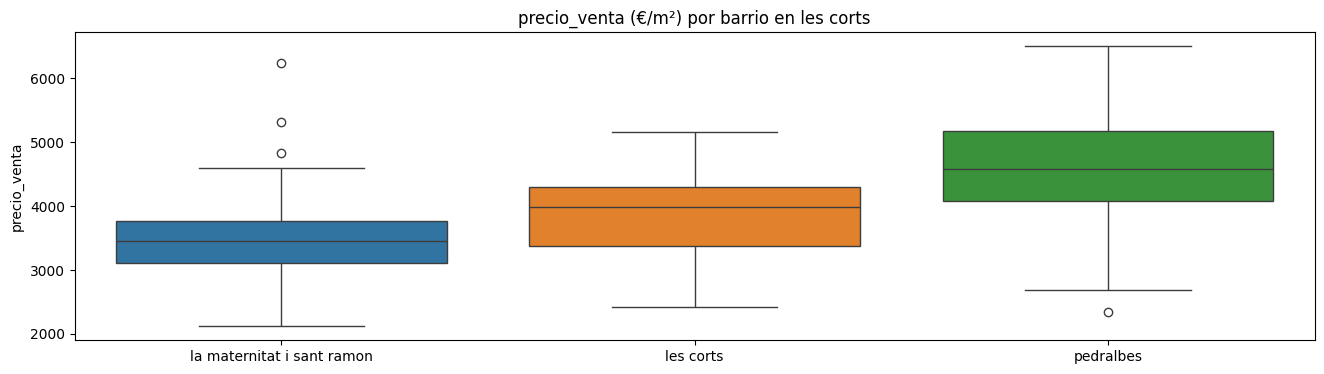

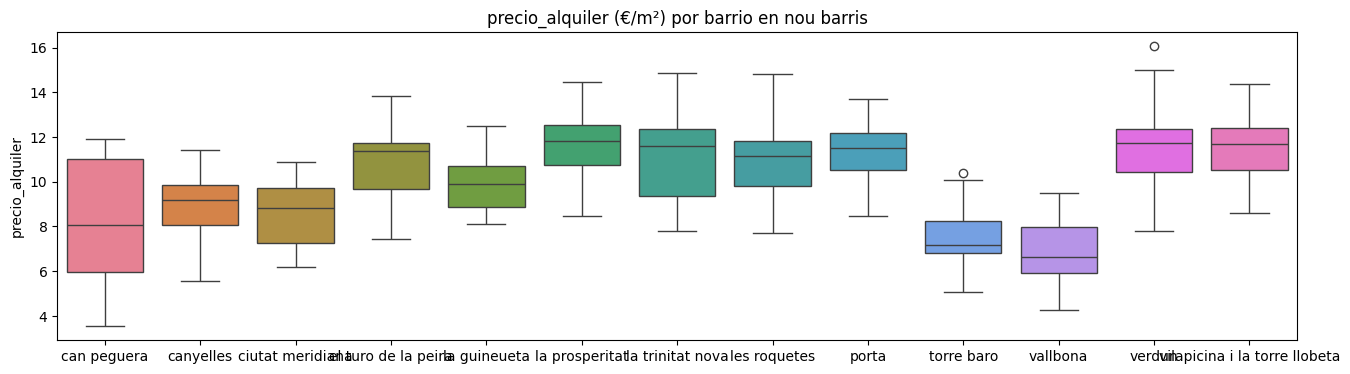

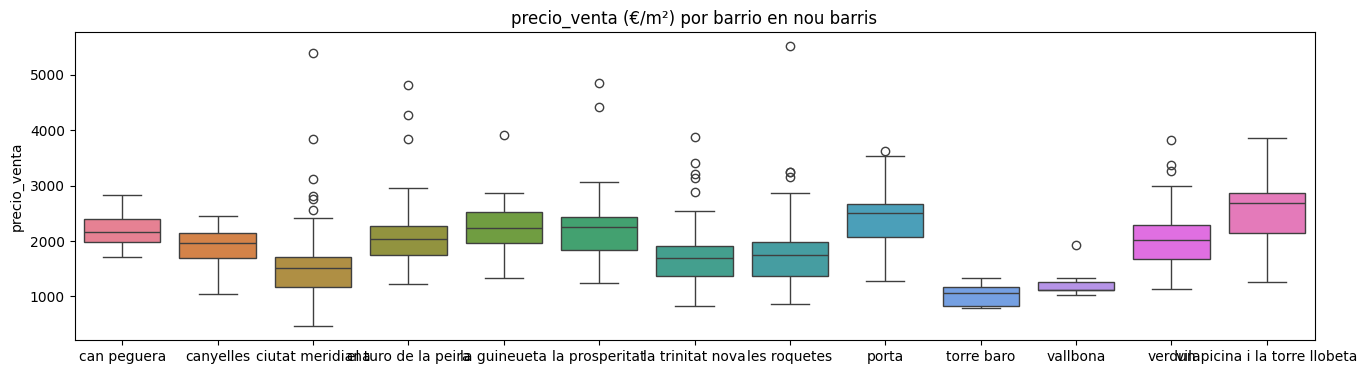

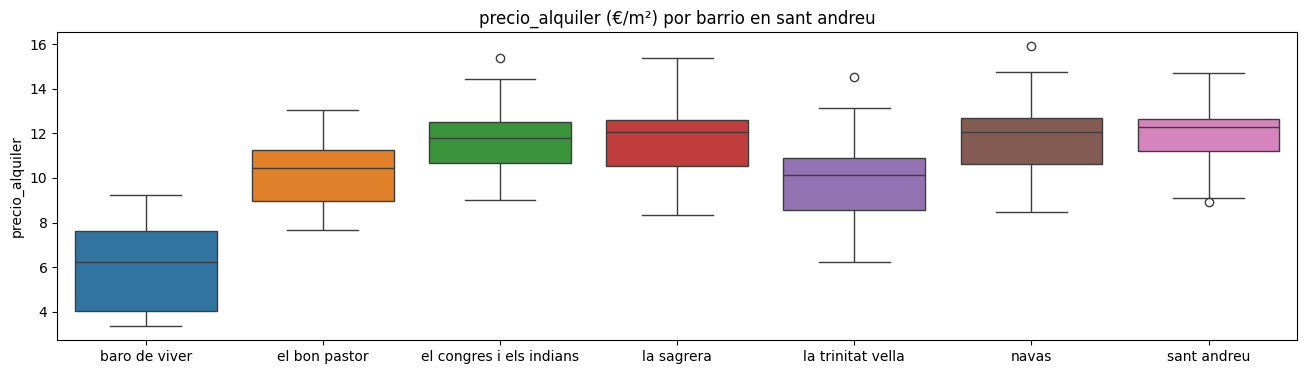

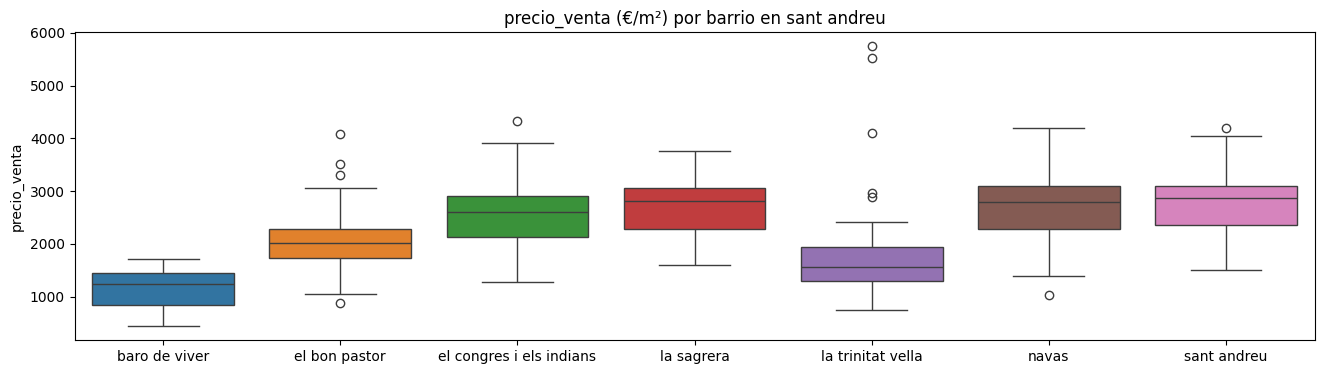

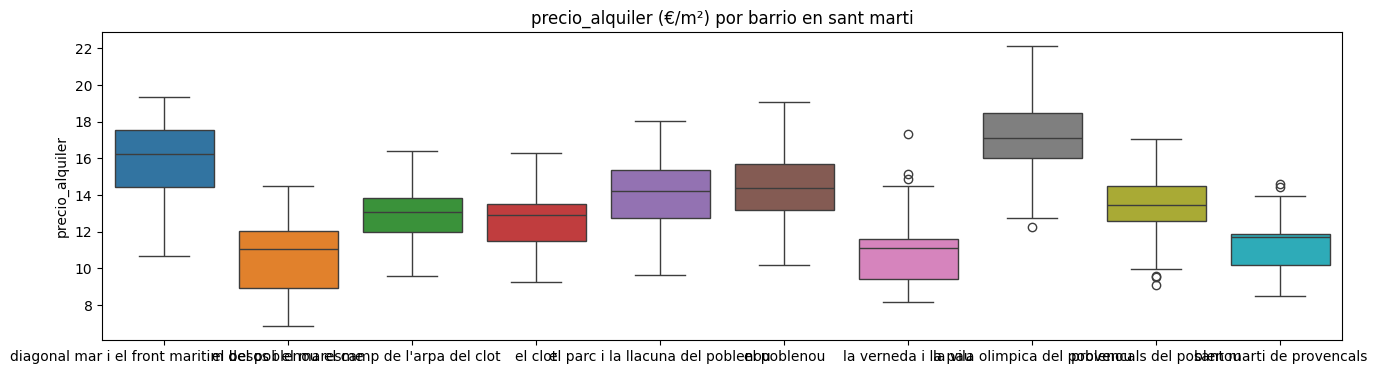

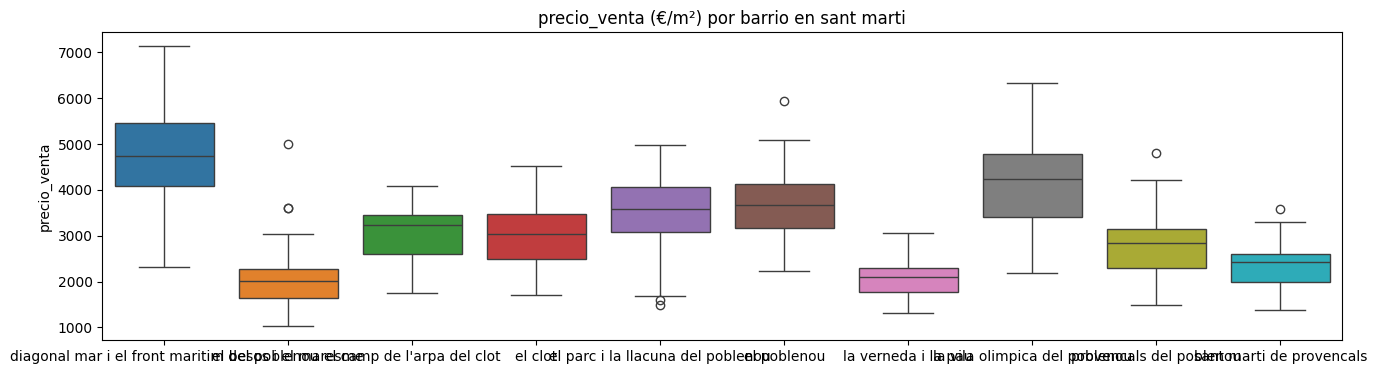

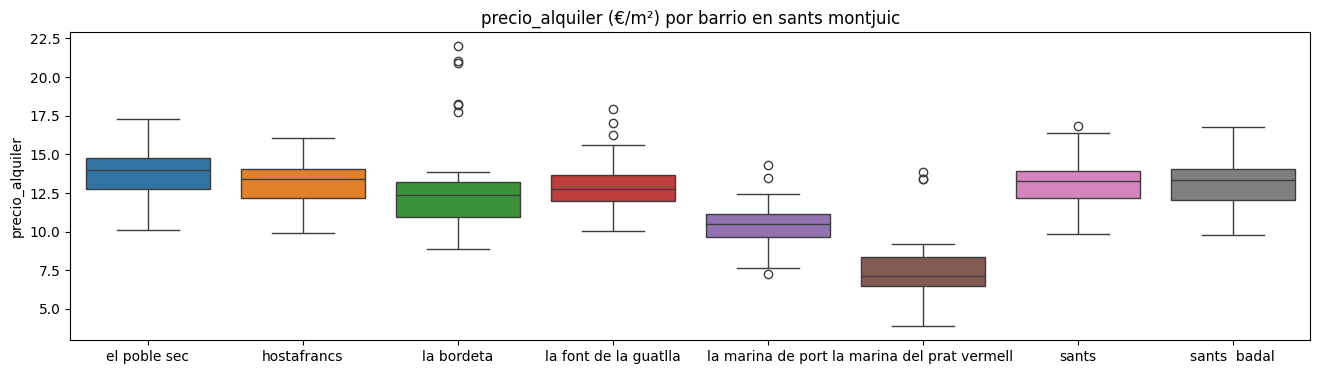

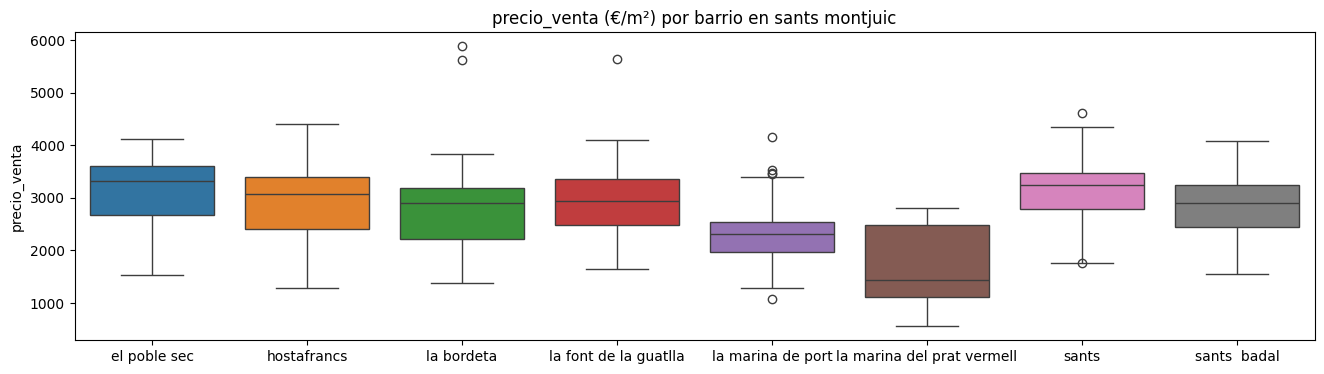

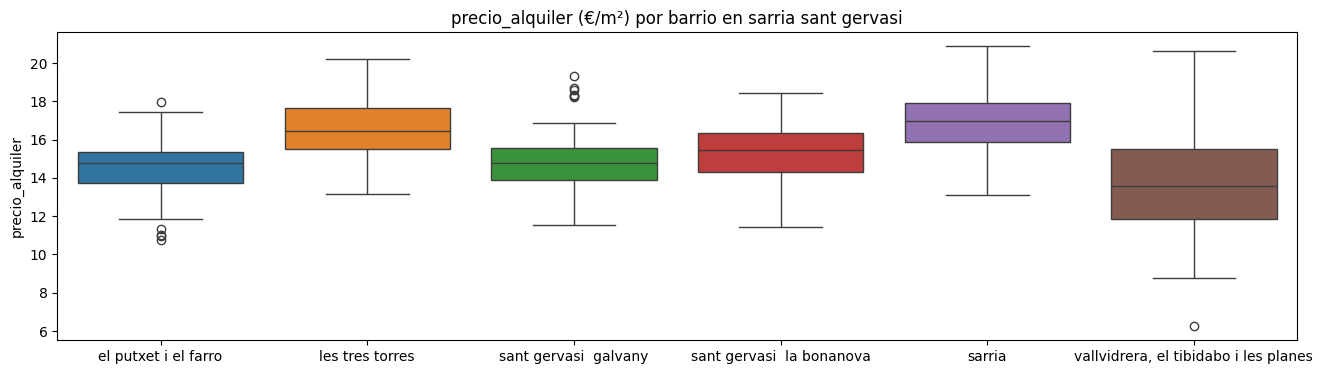

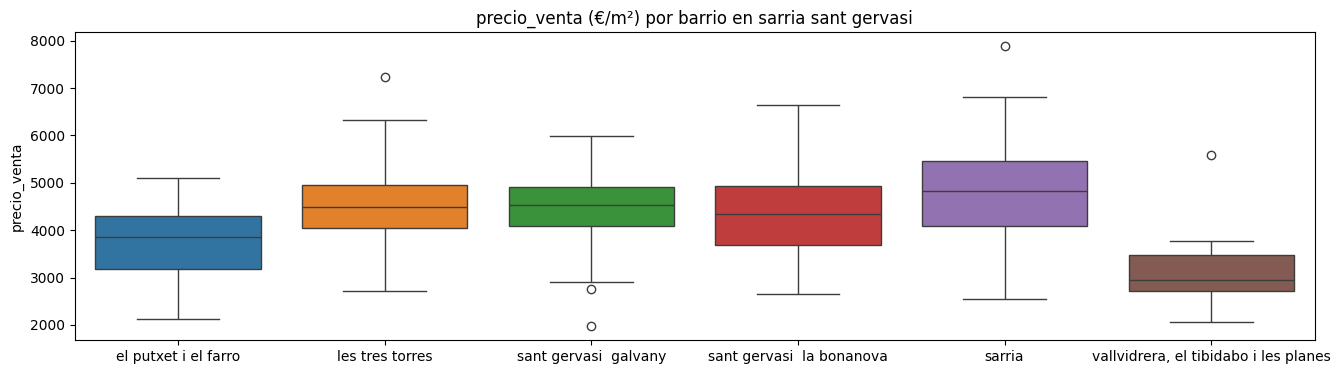

In [56]:
for y in ['precio_alquiler', 'precio_venta']:
    fig = plt.figure(figsize=(16, 4))
    sns.boxplot(bcn_precios[bcn_precios['tipo'] == 'districte'], x='nombre', y=y, hue='nombre')
    plt.xlabel("")
    plt.title(f'{y} (€/m²) por distrito')
    plt.show()


for dist in bcn_precios['nom_districte'].dropna().unique().tolist():
    for y in ['precio_alquiler', 'precio_venta']:
        fig = plt.figure(figsize=(16, 4))
        sns.boxplot(bcn_precios[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'barri')], x='nombre', y=y, hue='nombre')
        plt.xlabel("")
        plt.title(f'{y} (€/m²) por barrio en {dist}')
        plt.show()


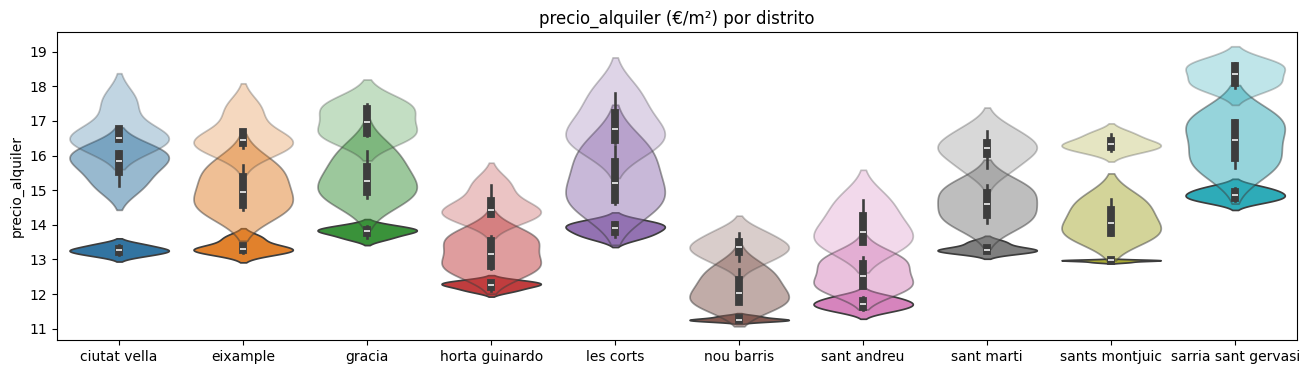

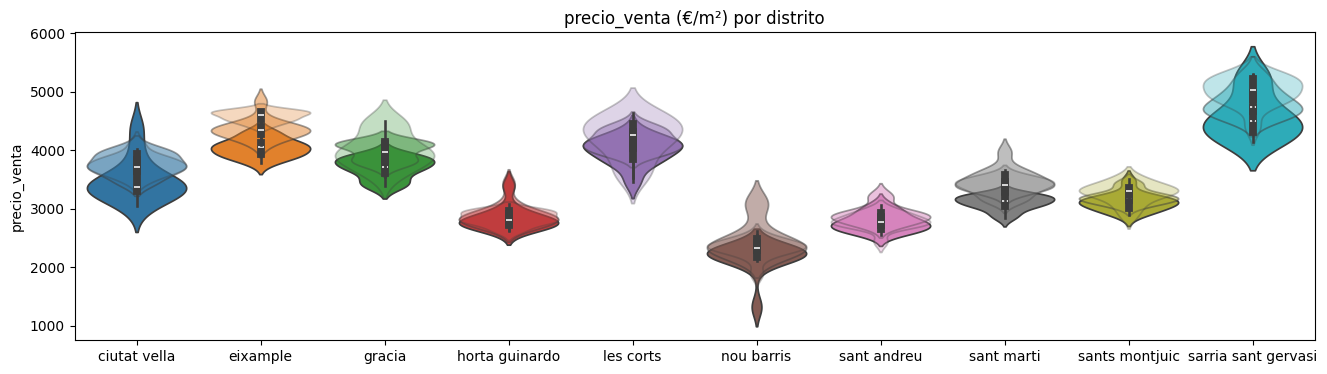

In [57]:
for y in ['precio_alquiler', 'precio_venta']:
    fig = plt.figure(figsize=(16, 4))
    sns.violinplot(bcn_precios[(bcn_precios['tipo'] == 'districte') & (bcn_precios['mes'].dt.year == 2021)], x='nombre', y=y, hue='nombre', split=False)
    sns.violinplot(bcn_precios[(bcn_precios['tipo'] == 'districte') & (bcn_precios['mes'].dt.year == 2022)], x='nombre', y=y, hue='nombre', split=False, alpha=0.5)
    sns.violinplot(bcn_precios[(bcn_precios['tipo'] == 'districte') & (bcn_precios['mes'].dt.year == 2023)], x='nombre', y=y, hue='nombre', split=False, alpha=0.3)
    plt.xlabel("")
    plt.title(f'{y} (€/m²) por distrito')
    plt.show()

In [59]:
bcn_precios_barri = bcn_precios[bcn_precios['tipo'] == 'barri' ].drop('tipo', axis=1).copy()
bcn_precios_dist = bcn_precios[bcn_precios['tipo'] == 'districte' ].drop('tipo', axis=1).copy()
bcn_precios_muni = bcn_precios[bcn_precios['tipo'] == 'municipi' ].drop('tipo', axis=1).copy()

bcn_precios_dist


hood_qtr = bcn_precios_barri.dropna().pivot(index='nombre', columns='mes', values='precio_alquiler').reset_index()
dist_qtr = bcn_precios_dist.dropna().pivot(index='nombre', columns='mes', values='precio_alquiler').reset_index()
town_qtr = bcn_precios_muni.dropna().pivot(index='nombre', columns='mes', values='precio_alquiler').reset_index()

display(dist_qtr[dist_qtr['nombre'] == 'ciutat vella'].round(2).reset_index(drop=True))
display(hood_qtr[hood_qtr['nombre'].isin(bcn_precios[bcn_precios['nom_districte'] == 'ciutat vella']['nombre'])].round(2).reset_index(drop=True))

mes        nombre  2014-01-01 00:00:00+00:00  2014-04-01 00:00:00+00:00  \
0    ciutat vella                      11.38                      11.29   

mes  2014-07-01 00:00:00+00:00  2014-10-01 00:00:00+00:00  \
0                        11.19                      11.63   

mes  2015-01-01 00:00:00+00:00  2015-04-01 00:00:00+00:00  \
0                         12.1                      12.13   

mes  2015-07-01 00:00:00+00:00  2015-10-01 00:00:00+00:00  \
0                        13.02                      12.88   

mes  2016-01-01 00:00:00+00:00  ...  2022-01-01 00:00:00+00:00  \
0                        13.59  ...                      16.02   

mes  2022-04-01 00:00:00+00:00  2022-07-01 00:00:00+00:00  \
0                        15.12                      16.12   

mes  2022-10-01 00:00:00+00:00  2023-01-01 00:00:00+00:00  \
0                        15.65                      16.52   

mes  2023-04-01 00:00:00+00:00  2023-07-01 00:00:00+00:00  \
0                        16.48                      16.42   

mes  2023-10-01 00:00:00+00:00  2024-01-01 00:00:00+00:00  \
0                        17.55                      17.09   

mes  2024-04-01 00:00:00+00:00  
0                        16.25  

[1 rows x 43 columns]

mes                                 nombre  2014-01-01 00:00:00+00:00  \
0                           el barri gotic                      10.56   
1                                 el raval                      10.62   
2                           la barceloneta                      14.78   
3    sant pere, santa caterina i la ribera                      11.12   

mes  2014-04-01 00:00:00+00:00  2014-07-01 00:00:00+00:00  \
0                        10.18                      10.99   
1                        10.52                       9.84   
2                        14.53                      15.54   
3                        11.23                      11.59   

mes  2014-10-01 00:00:00+00:00  2015-01-01 00:00:00+00:00  \
0                        10.41                      10.83   
1                        10.81                      10.85   
2                        16.14                      16.00   
3                        11.09                      12.10   

mes  2015-04-01 00:00:00+00:00  2015-07-01 00:00:00+00:00  \
0                        11.07                      11.72   
1                        10.92                      11.35   
2                        16.00                      17.07   
3                        12.02                      13.82   

mes  2015-10-01 00:00:00+00:00  2016-01-01 00:00:00+00:00  ...  \
0                        11.64                      13.26  ...   
1                        11.47                      11.96  ...   
2                        16.66                      17.74  ...   
3                        13.43                      13.52  ...   

mes  2022-01-01 00:00:00+00:00  2022-04-01 00:00:00+00:00  \
0                        16.44                      14.70   
1                        15.38                      14.66   
2                        20.03                      16.61   
3                        15.68                      15.82   

mes  2022-07-01 00:00:00+00:00  2022-10-01 00:00:00+00:00  \
0                        15.81                      14.75   
1                        15.37                      15.30   
2                        17.65                      19.63   
3                        17.02                      16.11   

mes  2023-01-01 00:00:00+00:00  2023-04-01 00:00:00+00:00  \
0                        16.53                      16.61   
1                        15.85                      15.27   
2                        18.47                      18.30   
3                        17.03                      17.63   

mes  2023-07-01 00:00:00+00:00  2023-10-01 00:00:00+00:00  \
0                         15.5                      16.98   
1                         15.6                      17.10   
2                         19.9                        NaN   
3                         17.7                      17.90   

mes  2024-01-01 00:00:00+00:00  2024-04-01 00:00:00+00:00  
0                        16.17                      15.30  
1                        16.57                      15.11  
2                        21.31                      20.36  
3                        17.59                      17.68  

[4 rows x 43 columns]

In [60]:
import re
ideal = pd.read_csv('datasets/idealista_datafile.csv')
ideal.head()


link type_v  \
0  /inmueble/106596114/   Piso   
1  /inmueble/106592827/   Piso   
2  /inmueble/106590362/   Piso   
3  /inmueble/106586185/   Piso   
4  /inmueble/106585942/   Piso   

                                             address  \
0  Ciutat Meridiana - Torre Baró - Vallbona, Barc...   
1  calle del Pare Manjón, La Trinitat Vella, Barc...   
2   calle de Vidal i Guasch, Les Roquetes, Barcelona   
3            calle de Palerm, 6, El Besòs, Barcelona   
4  calle de Vallcivera, 22, Ciutat Meridiana - To...   

                                                town   price  price_old  \
0  Ciutat Meridiana - Torre Baró - Vallbona, Barc...  69.875        NaN   
1  calle del Pare Manjón, La Trinitat Vella, Barc...  69.000        NaN   
2   calle de Vidal i Guasch, Les Roquetes, Barcelona  95.000        NaN   
3            calle de Palerm, 6, El Besòs, Barcelona  88.500        NaN   
4  calle de Vallcivera, 22, Ciutat Meridiana - To...  95.200        NaN   

                                                info  \
0  ['2 hab.', '54 m²', 'Planta 5ª exterior sin as...   
1      ['3 hab.', '41 m²', 'Planta -1 sin ascensor']   
2  ['2 hab.', '65 m²', 'Planta 1ª exterior sin as...   
3  ['3 hab.', '54 m²', 'Planta 2ª interior con as...   
4  ['3 hab.', '66 m²', 'Planta 2ª interior con as...   

                                         description                 tags  \
0  <p class="ellipsis">INMUEBLE SIN POSESION / VI...                  NaN   
1  <p class="ellipsis">Oportunidad sólo para inve...                  NaN   
2  <p class="ellipsis">Housfy vende piso alquilad...                  NaN   
3  <p class="ellipsis">Inmueble ocupado ideal par...  Ocupada ilegalmente   
4  <p class="ellipsis">Inmueble ocupado ideal par...  Ocupada ilegalmente   

   agent              created  
0    NaN  2024-11-20 14:42:36  
1    NaN  2024-11-20 14:42:36  
2    NaN  2024-11-20 14:42:36  
3    NaN  2024-11-20 14:42:36  
4    NaN  2024-11-20 14:42:36

In [61]:

hab_rx = re.compile(r'\'(\d+?) hab\.\'')
m2_rx = re.compile(r'\'(\d+?) m²\'')
barrio_rx = re.compile(r"([^,]+),[^,]+$")

def get_hood(x):
    x1 = ''.join(barrio_rx.findall(x)).strip() 
    x1 = x1 if len(x1)>1 else x
    return estandarizar(x1)

ideal['n_hab'] = ideal['info'].map(lambda x: ''.join(hab_rx.findall(x)))
ideal['sup_m2'] = ideal['info'].map(lambda x: ''.join(m2_rx.findall(x)))
ideal['town'] = ideal['town'].map(get_hood)
ideal['description'] = ideal['description'].map(lambda x: re.sub(r"<.*?>", "", x))
ideal[['type_v','address', 'description']] = ideal[['type_v','address', 'description']].applymap(estandarizar)


ideal


NameError: name 'estandarizar' is not defined

In [ ]:
from difflib import SequenceMatcher
places = barrios['nom_barri'].unique().tolist() + barrios['nom_districte'].unique().tolist()

# tipo	precio	codi_districte	nom_districte	codi_barri
def find_place(x):
    match = None
    best = 0
    for y in places:
        ratio = SequenceMatcher(None, x, y).ratio()
        if ratio == 1:
            return (y, ratio)
        if ratio > best:
            best = ratio
            match = y
    return (match if best > 0.5 else None, round(best,2))


ideal[['barrio', 'barrio_ratio']] = pd.DataFrame(ideal['town'].map(find_place).tolist(), index=ideal.index)
ideal

link   type_v  \
0    /inmueble/106596114/     piso   
1    /inmueble/106592827/     piso   
2    /inmueble/106590362/     piso   
3    /inmueble/106586185/     piso   
4    /inmueble/106585942/     piso   
..                    ...      ...   
350  /inmueble/101127284/     piso   
351  /inmueble/104221726/     piso   
352  /inmueble/106627206/  estudio   
353  /inmueble/106625212/  estudio   
354  /inmueble/106625063/  estudio   

                                               address  \
0    ciutat meridiana  torre baro  vallbona, barcelona   
1    calle del pare manjon, la trinitat vella, barc...   
2     calle de vidal i guasch, les roquetes, barcelona   
3              calle de palerm, 6, el besos, barcelona   
4    calle de vallcivera, 22, ciutat meridiana  tor...   
..                                                 ...   
350  ciutat meridiana  torre baro  vallbona, barcelona   
351  calle de la foradada, la trinitat vella, barce...   
352          calle de granollers, el carmel, barcelona   
353      plaza de les palmeres, sant andreu, barcelona   
354          calle de granollers, el carmel, barcelona   

                                       town    price  price_old  \
0    ciutat meridiana  torre baro  vallbona   69.875        NaN   
1                         la trinitat vella   69.000        NaN   
2                              les roquetes   95.000        NaN   
3                                  el besos   88.500        NaN   
4    ciutat meridiana  torre baro  vallbona   95.200        NaN   
..                                      ...      ...        ...   
350  ciutat meridiana  torre baro  vallbona   98.000        NaN   
351                       la trinitat vella  100.000        NaN   
352                               el carmel   89.000        NaN   
353                             sant andreu   95.000        NaN   
354                               el carmel   89.000        NaN   

                                                  info  \
0    ['2 hab.', '54 m²', 'Planta 5ª exterior sin as...   
1        ['3 hab.', '41 m²', 'Planta -1 sin ascensor']   
2    ['2 hab.', '65 m²', 'Planta 1ª exterior sin as...   
3    ['3 hab.', '54 m²', 'Planta 2ª interior con as...   
4    ['3 hab.', '66 m²', 'Planta 2ª interior con as...   
..                                                 ...   
350                  ['3 hab.', '64 m²', 'Planta 5ª ']   
351               ['3 hab.', '92 m²', ' sin ascensor']   
352            ['34 m²', 'Bajo exterior sin ascensor']   
353            ['38 m²', 'Bajo exterior con ascensor']   
354            ['34 m²', 'Bajo exterior sin ascensor']   

                                           description                 tags  \
0    inmueble sin posesion / vivienda okupada!**sol...                  NaN   
1    oportunidad solo para inversores. el activo se...                  NaN   
2    housfy vende piso alquilado con una rentabilid...                  NaN   
3    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
4    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
..                                                 ...                  ...   
350  piso en barcelona, idoneo para familias. la vi...                  NaN   
351  piso de 93 m², de 32 dormitorios y 1 banos, en...                  NaN   
352  nos complace ofrecer este estudio a la venta, ...                  NaN   
353  grupo a&b presenta esta local estudio a la ven...                  NaN   
354  tenemos el agrado de presentar este estudio a ...                  NaN   

     agent              created n_hab sup_m2             barrio  barrio_ratio  
0      NaN  2024-11-20 14:42:36     2     54   ciutat meridiana          0.59  
1      NaN  2024-11-20 14:42:36     3     41  la trinitat vella          1.00  
2      NaN  2024-11-20 14:42:36     2     65       les roquetes          1.00  
3      NaN  2024-11-20 14:42:36     3     54        el poblenou          0.63  
4      NaN  2024

In [ ]:
!pip install gradio_client

from gradio_client import Client, handle_file

def connect_gradio(endpoint, mode, system_prompt):
    # mode Literal['RAG', 'Search', 'Basic', 'Summarize'] Default: "RAG"
    client = Client(endpoint)
    client.predict(api_name="/_set_current_mode", mode=mode)
    client.predict(api_name="/_set_system_prompt", system_prompt_input=system_prompt)
    return client

endpoint = "http://0.0.0.0:8001/"
mode="Basic"
system_prompt = "eres un clasificador de viviendas que tienes que decidir cual de estas 3 categoría es la más probable: [disponible, alquilada, ocupada]. Solo debes responder con una palabra, sin saludos ni otros comentarios."
# client = connect_gradio(endpoint, mode, system_prompt)

In [ ]:

def get_occupation(description):
    try:
        return client.predict(api_name="/chat", message=description, mode="Basic",param_3=[handle_file('https://github.com/gradio-app/gradio/raw/main/test/test_files/sample_file.pdf')],param_4="")
    finally:
        return None

# ideal[ideal['ocupacion'] is None]['ocupacion'] = ideal.description.map(lambda x: get_occupation(x))

ideal

link   type_v  \
0    /inmueble/106596114/     piso   
1    /inmueble/106592827/     piso   
2    /inmueble/106590362/     piso   
3    /inmueble/106586185/     piso   
4    /inmueble/106585942/     piso   
..                    ...      ...   
350  /inmueble/101127284/     piso   
351  /inmueble/104221726/     piso   
352  /inmueble/106627206/  estudio   
353  /inmueble/106625212/  estudio   
354  /inmueble/106625063/  estudio   

                                               address  \
0    ciutat meridiana  torre baro  vallbona, barcelona   
1    calle del pare manjon, la trinitat vella, barc...   
2     calle de vidal i guasch, les roquetes, barcelona   
3              calle de palerm, 6, el besos, barcelona   
4    calle de vallcivera, 22, ciutat meridiana  tor...   
..                                                 ...   
350  ciutat meridiana  torre baro  vallbona, barcelona   
351  calle de la foradada, la trinitat vella, barce...   
352          calle de granollers, el carmel, barcelona   
353      plaza de les palmeres, sant andreu, barcelona   
354          calle de granollers, el carmel, barcelona   

                                       town    price  price_old  \
0    ciutat meridiana  torre baro  vallbona   69.875        NaN   
1                         la trinitat vella   69.000        NaN   
2                              les roquetes   95.000        NaN   
3                                  el besos   88.500        NaN   
4    ciutat meridiana  torre baro  vallbona   95.200        NaN   
..                                      ...      ...        ...   
350  ciutat meridiana  torre baro  vallbona   98.000        NaN   
351                       la trinitat vella  100.000        NaN   
352                               el carmel   89.000        NaN   
353                             sant andreu   95.000        NaN   
354                               el carmel   89.000        NaN   

                                                  info  \
0    ['2 hab.', '54 m²', 'Planta 5ª exterior sin as...   
1        ['3 hab.', '41 m²', 'Planta -1 sin ascensor']   
2    ['2 hab.', '65 m²', 'Planta 1ª exterior sin as...   
3    ['3 hab.', '54 m²', 'Planta 2ª interior con as...   
4    ['3 hab.', '66 m²', 'Planta 2ª interior con as...   
..                                                 ...   
350                  ['3 hab.', '64 m²', 'Planta 5ª ']   
351               ['3 hab.', '92 m²', ' sin ascensor']   
352            ['34 m²', 'Bajo exterior sin ascensor']   
353            ['38 m²', 'Bajo exterior con ascensor']   
354            ['34 m²', 'Bajo exterior sin ascensor']   

                                           description                 tags  \
0    inmueble sin posesion / vivienda okupada!**sol...                  NaN   
1    oportunidad solo para inversores. el activo se...                  NaN   
2    housfy vende piso alquilado con una rentabilid...                  NaN   
3    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
4    inmueble ocupado ideal para invertir,imposibil...  Ocupada ilegalmente   
..                                                 ...                  ...   
350  piso en barcelona, idoneo para familias. la vi...                  NaN   
351  piso de 93 m², de 32 dormitorios y 1 banos, en...                  NaN   
352  nos complace ofrecer este estudio a la venta, ...                  NaN   
353  grupo a&b presenta esta local estudio a la ven...                  NaN   
354  tenemos el agrado de presentar este estudio a ...                  NaN   

     agent              created n_hab sup_m2             barrio  barrio_ratio  
0      NaN  2024-11-20 14:42:36     2     54   ciutat meridiana          0.59  
1      NaN  2024-11-20 14:42:36     3     41  la trinitat vella          1.00  
2      NaN  2024-11-20 14:42:36     2     65       les roquetes          1.00  
3      NaN  2024-11-20 14:42:36     3     54        el poblenou          0.63  
4      NaN  2024

In [ ]:
# ideal.to_csv('datasets/idealista_datafile_new.csv', index=False)